# What's in the Wind?: Evaluating Air Quality Trends in the United States Since 1990

Contributors: Alexander Heger, Yu Ting Hung, Ishan Nagrani, Lingxuan Wang, Fanfei Zhao

----

### Table of Contents

> 1. [Report Summary](#part1)
> 2. [Introduction](#part2)
> 3. [Challenges](#part3)
> 4. [Data Cleaning](#part4)
> 5. [Data Analysis](#part5)
> 6. [Machine Learning Application](#part6)
> 7. [Conclusions](#part7)
> 8. [References](#part8)
> 9. [Appendix](#part9)

----


<a id="part1"></a>
## Part 1: Report Summary

This report analyzes over 30 years of air quality data from the United States Environmental Protection Agency's 3,327 measurement sites across the U.S. to characterize regional trends and to estimate daily air quality indices (AQI) given pollutant concentrations.  We focus primarily on airborne pollutants whose impact on health spurred the approval of the 1990 Clean Air Act: Carbon Monoxide ($ CO $), Nitrogen Dioxide ($ NO_2 $), Sulfur Dioxide ($ SO_2 $), Ozone ($ O_3 $), Particulate Matter-2.5 microns ($ PM_{2.5} $), and Particulate Matter-10 microns ($ PM_{10} $).  We display the seasonality of each of these pollutants based on region, and demonstrate the impact of human and environmental activity on their concentrations.  Finally, we use statistical learning to train 3 regression models to predict daily AQI given pollutant information in combination with wind and temperature.



----


<a id="part2"></a>
## Part 2: Introduction 

### 2.1. Problem Statement

Our goal is to illustrate trends in air quality in the United States, identifying which pollutants have contributed most to air quality changes over the years. Our analysis will include how weather, natural disasters, and select world events affect air quality as measured by the U.S. Environmental Protection Agency (EPA). We will use Google Cloud Platform's (GCP) Dataproc service to distribute and interact with daily air quality information from the EPA's Historical Air Quality data set (hosted on BigQuery) which includes data from collection points across the U.S. dating back to 1990.

### 2.2. Motivation

Air pollution is a significant problem with adverse health outcomes, so understanding air quality trends is crucial for effective management strategies. In this study, we explore six pollutants that were key drivers of the 1990 Clean Air Act whose standards brought about the generation of our data set. We chose this problem based on our knowledge that historical air quality data can identify sources of pollution, inform targeted interventions, and aid in the development of evidence-based approaches that promote environmental sustainability and protect public health.

### 2.3. Data Source

The EPA Historical Air Quality data set is hosted here on __[Google Cloud Platform](https://console.cloud.google.com/marketplace/product/epa/historical-air-quality)__.

The EPA's documentation for the data set can be found __[here](https://aqs.epa.gov/aqsweb/airdata/FileFormats.html)__. 

The data set takes on the following schema:

|        | Field Name          | Type    | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |   |   |   |   |   |
|--------|---------------------|---------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---|---|---|---|---|
| **1**  | state_code          | STRING  | The FIPS code of the state in which the monitor resides.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |   |   |   |   |   |
| **2**  | county_code         | STRING  | The FIPS code of the county in which the monitor resides.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |   |   |   |   |   |
| **3**  | site_num            | STRING  | A unique number within the county identifying the site.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |   |   |   |   |   |
| **4**  | parameter_code      | INTEGER | The AQS code corresponding to the parameter measured by the monitor.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |   |   |   |   |   |
| **5**  | poc                 | INTEGER | This is the “Parameter Occurrence Code” used to distinguish different instruments that measure the same parameter at the same site.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |   |   |   |   |   |
| **6**  | latitude            | FLOAT   | The monitoring site’s angular distance north of the equator measured in decimal degrees.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |   |   |   |   |   |
| **7**  | longitude           | FLOAT   | The monitoring site’s angular distance east of the prime meridian measured in decimal degrees.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |   |   |   |   |   |
| **8**  | datum               | STRING  | The Datum associated with the Latitude and Longitude measures.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |   |   |   |   |   |
| **9**  | parameter_name      | STRING  | The name or description assigned in AQS to the parameter measured by the monitor. Parameters may be pollutants or non-pollutants.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |   |   |   |   |   |
| **10** | sample_duration     | STRING  | The length of time that air passes through the monitoring device before it is analyzed (measured). So, it represents an averaging period in the atmosphere (for example, a 24-hour sample duration draws ambient air over a collection filter for 24 straight hours). For continuous monitors, it can represent an averaging time of many samples (for example, a 1-hour value may be the average of four one-minute samples collected during each quarter of the hour).                                                                                                                                                                                                             |   |   |   |   |   |
| **11** | pollutant_standard  | STRING  | A description of the ambient air quality standard rules used to aggregate statistics. (See description at beginning of document.)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |   |   |   |   |   |
| **12** | date_local          | DATE    | The calendar date for the summary. All daily summaries are for the local standard day (midnight to midnight) at the monitor.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |   |   |   |   |   |
| **13** | units_of_measure    | STRING  | The unit of measure for the parameter. QAD always returns data in the standard units for the parameter. Submitters are allowed to report data in any unit and EPA converts to a standard unit so that we may use the data in calculations.                                                                                                                                                                                                                                                                                                                                                                                                                                           |   |   |   |   |   |
| **14** | event_type          | STRING  | Indicates whether data measured during exceptional events are included in the summary. A wildfire is an example of an exceptional event; it is something that affects air quality, but the local agency has no control over. No Events means no events occurred. Events Included means events occurred and the data from them is included in the summary. Events Excluded means that events occurred but data from them is excluded from the summary. Concurred Events Excluded means that events occurred but only EPA concurred exclusions are removed from the summary. If an event occurred for the parameter in question, the data will have multiple records for each monitor. |   |   |   |   |   |
| **15** | observation_count   | INTEGER | The number of observations (samples) taken during the day.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |   |   |   |   |   |
| **16** | observation_percent | FLOAT   | The percent representing the number of observations taken with respect to the number scheduled to be taken during the day. This is only calculated for monitors where measurements are required (e.g., only certain parameters).                                                                                                                                                                                                                                                                                                                                                                                                                                                     |   |   |   |   |   |
| **17** | arithmetic_mean     | FLOAT   | The average (arithmetic mean) value for the day.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |   |   |   |   |   |
| **18** | first_max_value     | FLOAT   | The highest value for the day.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |   |   |   |   |   |
| **19** | first_max_hour      | INTEGER | The hour (on a 24-hour clock) when the highest value for the day (the previous field) was taken.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |   |   |   |   |   |
| **20** | aqi                 | INTEGER | The Air Quality Index for the day for the pollutant, if applicable.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |   |   |   |   |   |
| **21** | method_code         | INTEGER | An internal system code indicating the method (processes, equipment, and protocols) used in gathering and measuring the sample. The method name is in the next column.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |   |   |   |   |   |
| **22** | method_name         | STRING  | A short description of the processes, equipment, and protocols used in gathering and measuring the sample.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |   |   |   |   |   |
| **23** | local_site_name     | STRING  | The name of the site (if any) given by the State, local, or tribal air pollution control agency that operates it.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |   |   |   |   |   |
| **24** | address             | STRING  | The approximate street address of the monitoring site.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |   |   |   |   |   |
| **25** | state_name          | STRING  | The name of the state where the monitoring site is located.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |   |   |   |   |   |
| **26** | county_name         | STRING  | The name of the county where the monitoring site is located.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |   |   |   |   |   |
| **27** | city_name           | STRING  | The name of the city where the monitoring site is located. This represents the legal incorporated boundaries of cities and not urban areas.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |   |   |   |   |   |
| **28** | cbsa_name           | STRING  | The name of the core bases statistical area (metropolitan area) where the monitoring site is located.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |   |   |   |   |   |
| **29** | date_of_last_change | DATE    | The date the last time any numeric values in this record were updated in the AQS data system.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |   |   |   |   |   |


----


<a id="part3"></a>
## Part 3: Challenges

### 3.1. Computing

The first challenge we encountered was related to computing. Given that we needed to deal with eight tables, it became necessary for our cluster to scale up in order to run multiple notebooks which can be computationally expensive. To address this challenge, we decided to concatenate the eight tables together and kept their *TIDY* structure. This approach simplified the data processing pipeline and reduced the computational load, thereby enabling more efficient analysis.

### 3.2. Data Wrangling

The second challenge was related to data wrangling. We first chose six pollutants and two meteorological information based on the information provided by [AirNow](https://www.airnow.gov/aqi/aqi-basics/). They are Ground-level Ozone, Particle Pollution (including $ PM_{2.5} $ and $ PM_{10} $), Carbon Monoxide, Sulfur Dioxide, Nitrogen Dioxide, Wind, and Temperature. Each pollutant has distinct measurements that need to be analyzed separately, which made data wrangling a complex task. Our approach was to develop a standardized data cleaning, collecting, and preprocessing pipeline that could be applied uniformly across all tables. We make our final table recording the wind speed, temperature, and AQI of each pollutants at each site in each date with the geographical information of the site. In this way, we can ensure that our analysis is accurate and reliable.

----

<a id="part4"></a>
## Part 4 : Data Cleaning

### 4.1. Append Tables

We elected to append six data tables, containing information on our pollutants of interest, into one large table in order to limit the need for many smaller tables relevant to distinct calculations.  The following code blocks detail how we merged all our information into one place.  

We begin by reading each table name and loading it in a sequence, before using the `unionByName` method to merge each table into `merged_df`.

In [36]:
table_names = [
    "bigquery-public-data.epa_historical_air_quality.no2_daily_summary",
    "bigquery-public-data.epa_historical_air_quality.pm10_daily_summary",
    "bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary",
    "bigquery-public-data.epa_historical_air_quality.o3_daily_summary",
    "bigquery-public-data.epa_historical_air_quality.co_daily_summary",
    "bigquery-public-data.epa_historical_air_quality.so2_daily_summary",
]

# Read all tables
dataframes = {}
for table_name in table_names:
    dataframes[table_name] = spark.read \
        .format("bigquery") \
        .option("table", table_name) \
        .load()

# Create merged_df
merged_df = dataframes[table_names[0]]

# Append all tables to merged_df
for table_name in table_names[1:]:
    merged_df = merged_df.unionByName(dataframes[table_name])
    
# Validate schema of merged_df
merged_df.printSchema()

root
 |-- state_code: string (nullable = true)
 |-- county_code: string (nullable = true)
 |-- site_num: string (nullable = true)
 |-- parameter_code: long (nullable = true)
 |-- poc: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- datum: string (nullable = true)
 |-- parameter_name: string (nullable = true)
 |-- sample_duration: string (nullable = true)
 |-- pollutant_standard: string (nullable = true)
 |-- date_local: date (nullable = true)
 |-- units_of_measure: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- observation_count: long (nullable = true)
 |-- observation_percent: double (nullable = true)
 |-- arithmetic_mean: double (nullable = true)
 |-- first_max_value: double (nullable = true)
 |-- first_max_hour: long (nullable = true)
 |-- aqi: long (nullable = true)
 |-- method_code: long (nullable = true)
 |-- method_name: string (nullable = true)
 |-- local_site_name: string (nullable = true)
 |

### 4.2. Remove Redundant Columns

Through early exploration we identified 8 columns that were not relevant to our analysis.  We drop those columns from `merged_df` and rename the new table `all_pollutants_merged`. 

In [37]:
columns_to_drop = [
    "observation_percent",
    "first_max_value",
    "first_max_hour",
    "method_code",
    "method_name",
    "address",
    "cbsa_name",
    "date_of_last_change",
]

# Drop columns_to_drop
all_pollutants_merged = merged_df.drop(*columns_to_drop)

Next, we show how many rows our combined table contains, compared to the count of rows in each of the six individual pollutant tables.

In [38]:
# Count the number of rows in all_pollutants_merged
print("There are {} rows in the data table.".format(all_pollutants_merged.count()))

# Count the number of rows in each distinct table
table_counts = {}
for table_name, df in dataframes.items():
    count = df.count()
    table_counts[table_name] = count
    print(f"Total count of {table_name}: {count}")

There are 48629007 rows in the data table.
Total count of bigquery-public-data.epa_historical_air_quality.no2_daily_summary: 4523485
Total count of bigquery-public-data.epa_historical_air_quality.pm10_daily_summary: 4860727
Total count of bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary: 6589958
Total count of bigquery-public-data.epa_historical_air_quality.o3_daily_summary: 11141508
Total count of bigquery-public-data.epa_historical_air_quality.co_daily_summary: 8990270
Total count of bigquery-public-data.epa_historical_air_quality.so2_daily_summary: 12523059


In [39]:
# Prevent Pandas from delimiting columns
import pandas as pd
pd.set_option('display.max_columns', None)

# Show head of all_pollutants_merged
all_pollutants_merged.limit(3).toPandas()

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,sample_duration,pollutant_standard,date_local,units_of_measure,event_type,observation_count,arithmetic_mean,aqi,local_site_name,state_name,county_name,city_name
0,38,057,0001,42602,1,47.258853,-101.783035,WGS84,Nitrogen dioxide (NO2),1 HOUR,NO2 1-hour 2010,1990-09-18,Parts per billion,None,20,3.900000,15,None,North Dakota,Mercer,Beulah
1,38,057,0001,42602,1,47.258853,-101.783035,WGS84,Nitrogen dioxide (NO2),1 HOUR,NO2 1-hour 2010,1990-03-01,Parts per billion,None,21,3.619048,18,None,North Dakota,Mercer,Beulah
2,38,057,0001,42602,1,47.258853,-101.783035,WGS84,Nitrogen dioxide (NO2),1 HOUR,NO2 1-hour 2010,1990-06-11,Parts per billion,None,21,0.000000,0,None,North Dakota,Mercer,Beulah


### 4.3. Null & Negative Values Analysis

Finally, we want to know how many missing or negative values exist in our dataset.  Since all of our measurements indicate a quantity of an observed pollutant, none should be negative.

In [40]:
from pyspark.sql.functions import col, when, isnull, count

# Show count of all null values by column
all_pollutants_merged.select([count(when(isnull(col(each_col)), 1)).alias(f"{each_col}")\
                              for each_col in all_pollutants_merged.columns]).toPandas()

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,sample_duration,pollutant_standard,date_local,units_of_measure,event_type,observation_count,arithmetic_mean,aqi,local_site_name,state_name,county_name,city_name
0,0,0,0,0,0,0,0,0,0,0,1911323,0,0,0,0,0,12664142,7858526,0,0,0


It appears there are `1,911,323` null values for `pollutant_standard`, `12,664,142` null values for `aqi`, and `7,858,526` null values for `local_site_name`.  Since neither of these variables is critical to our analyses, we will not impute any missing values for now.

In [41]:
# Count all negative arithmetic_mean values in the data set
all_pollutants_merged.select("parameter_name", "arithmetic_mean")\
.where(all_pollutants_merged["arithmetic_mean"] < 0).count()

212017

In [42]:
# Show count of all negative arithmetic_mean values by pollutant
neg_count = all_pollutants_merged.groupBy("parameter_name")\
.agg(count(when(col("arithmetic_mean") < 0, 1)).alias("count"))
neg_count.toPandas()

,parameter_name,count
0,Nitrogen dioxide (NO2),8772
1,PM10 Total 0-10um STP,470
2,PM2.5 - Local Conditions,29369
3,Ozone,33
4,Carbon monoxide,13535
5,Sulfur dioxide,159838


There are `212,017` negative measurements for `arithmetic_mean`, which is impractical for this dataset.  We imputed all negative `arithmetic_mean` values to `0` since a negative measurement would be impossible.  We assess these negative values were due to issues with the measurements themselves, and/or extremely low (near `0`) concentrations of a pollutant.  Since the daily tables that we used from the EPA dataset offer only the max and arithmetic mean measurements for the day, we chose `arithmetic_mean` since it may be more indicative of pollution over the course of the day as a whole.  This means however that we could not impute negative values to be the mean of the same site on the same day, since that is what we are tracking to begin with.  We could have used the previous day's `arithmetic_mean` value from the same site, assuming that that value was also not negative.  However, we thought `0` was the closest feasible value to use when a negative value was recorded.  The imputed values account for `0.04`% of our total data.

In [43]:
# Impute negative values
imputed_mean = when(all_pollutants_merged['arithmetic_mean'] < 0, 0)\
.otherwise(all_pollutants_merged['arithmetic_mean'])

#Replace original values with imputed values
all_pollutants_merged = all_pollutants_merged.withColumn('arithmetic_mean', imputed_mean)

# Show head of all_pollutants_merged
all_pollutants_merged.limit(3).toPandas()

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,sample_duration,pollutant_standard,date_local,units_of_measure,event_type,observation_count,arithmetic_mean,aqi,local_site_name,state_name,county_name,city_name
0,38,057,0001,42602,1,47.258853,-101.783035,WGS84,Nitrogen dioxide (NO2),1 HOUR,NO2 1-hour 2010,1990-09-18,Parts per billion,None,20,3.900000,15,None,North Dakota,Mercer,Beulah
1,38,057,0001,42602,1,47.258853,-101.783035,WGS84,Nitrogen dioxide (NO2),1 HOUR,NO2 1-hour 2010,1990-03-01,Parts per billion,None,21,3.619048,18,None,North Dakota,Mercer,Beulah
2,38,057,0001,42602,1,47.258853,-101.783035,WGS84,Nitrogen dioxide (NO2),1 HOUR,NO2 1-hour 2010,1990-06-11,Parts per billion,None,21,0.000000,0,None,North Dakota,Mercer,Beulah


In [44]:
# Check to ensure there are no negative values remaining
all_pollutants_merged.cache()
all_pollutants_merged.select("parameter_name", "arithmetic_mean")\
.where(all_pollutants_merged["arithmetic_mean"] < 0).count()

0

### 4.4. Create New DataFrame with Wind and Temperature

In [45]:
from pyspark.sql.functions import col
from pyspark.sql.functions import *
from pyspark.sql.types import *

# list of pollutant names
tables = ['co', 'no2', 'o3', 'pm10', 'pm25_frm', 'so2', 'wind', 'temperature']

# empty dataframe to hold the concatenated tables
allyears_df = None

# load each pollutant table, rename the columns for each pollutant, and concatenate horizontally
for table in tables:
    # load the table
    allyears_table = spark.read.format('bigquery').option('table', f'bigquery-public-data.epa_historical_air_quality.{table}_daily_summary').load()
    # rename pm25 for column creation 
    if table == 'pm25_frm':
        table = 'pm25'
    # filter wind table
    if table == 'wind':
        allyears_table = allyears_table.filter(col("units_of_measure").isin(["Knots"]))
    # filter null api value
    if table != 'wind' and table != 'temperature':
        allyears_table = allyears_table.filter(col("aqi").isNotNull())
    # rename the columns according to each pollutant
    allyears_temp = allyears_table.select(['county_code', 'site_num', 'date_local', *[col(x).alias(f"{table}_{x}") for x in ['arithmetic_mean','aqi']]])
    # concatenate horizontally
    if allyears_df is None:
        allyears_df = allyears_temp
    else:
        allyears_df = allyears_df.join(allyears_temp, ['date_local','county_code', 'site_num'], 'outer')


# Drop columns_to_drop
columns_to_drop = ['wind_aqi', 'temperature_aqi']
allyears_df = allyears_df.drop(*columns_to_drop)

# Cache the result
allyears_df.cache()

DataFrame[date_local: date, county_code: string, site_num: string, co_arithmetic_mean: double, co_aqi: bigint, no2_arithmetic_mean: double, no2_aqi: bigint, o3_arithmetic_mean: double, o3_aqi: bigint, pm10_arithmetic_mean: double, pm10_aqi: bigint, pm25_arithmetic_mean: double, pm25_aqi: bigint, so2_arithmetic_mean: double, so2_aqi: bigint, wind_arithmetic_mean: double, temperature_arithmetic_mean: double]

In [46]:
from pyspark.sql.functions import year

# filter the DataFrame to 20 years
start_year = 2002
end_year = 2022

twentyYears_df = allyears_df.filter((year('date_local') >= start_year) & (year('date_local') <= end_year))

twentyYears_df.cache()

DataFrame[date_local: date, county_code: string, site_num: string, co_arithmetic_mean: double, co_aqi: bigint, no2_arithmetic_mean: double, no2_aqi: bigint, o3_arithmetic_mean: double, o3_aqi: bigint, pm10_arithmetic_mean: double, pm10_aqi: bigint, pm25_arithmetic_mean: double, pm25_aqi: bigint, so2_arithmetic_mean: double, so2_aqi: bigint, wind_arithmetic_mean: double, temperature_arithmetic_mean: double]

Our cleaned table is now ready to be used for data analysis.

-----

<a id="part5"></a>
## Part 5: Data Analysis

### 5.1. Summary Statistics

#### 5.1.1. Range of Dates Measured

In order to better understand the timeframe that this dataset measures, we examine the earliest and latest measurement dates. This table contains measurements from January 1, 1990 to June 1, 2022.

In [47]:
from pyspark.sql.functions import min, max

# Show min and max dates
all_pollutants_merged.select(min("date_local"), max("date_local")).toPandas()

,min(date_local),max(date_local)
0,1990-01-01,2022-06-01


#### 5.1.2. Number of Sites

We then asked, how many sites does the EPA leverage to measure air pollutants in accordance with the Clean Air Act of 1990?  In fact, there are `3,327` distinctly numbered sites in our table.

In [48]:
# Print count of distinct sites by site_num
sites = all_pollutants_merged.select('site_num', 'state_code').distinct()
print("There are ", sites.count(), " sites.")

There are  3327  sites.


#### 5.1.3. Map of Measurement Sites

Given geolocation data for each of the EPA's `3,327` measurement sites, we can generate a simple visualization of their approximate location by plotting longitude and latitude on an X and Y plane.

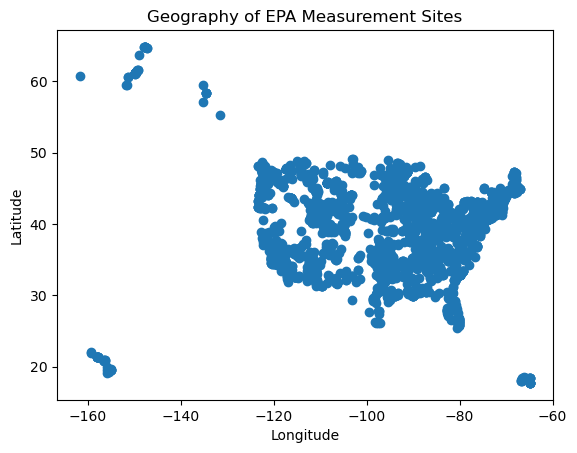

In [51]:
# Plot site geos
site_locations = all_pollutants_merged.dropDuplicates(['site_num', 'state_code'])\
.select('latitude', 'longitude').where((all_pollutants_merged['latitude'] > 0) &
                                       (all_pollutants_merged['longitude'] < 0)).toPandas()

lat = site_locations['latitude']
lon = site_locations['longitude']


plt.scatter(lon, lat)
plt.title('Geography of EPA Measurement Sites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

The following is an interactive map of the `3,327` distinct measurement sites located throughout the United States. This map makes clear that sites appear to be the most dense in California, Texas and Oklahoma, and New England with noticeable concentrations along the North-South Interstate corridors, I-5, I-35, and I-95. We assess that this is due to population density in addition to the occurrence of key weather events in these same regions.  (__Note:__ In order to visualize the Folium map, you must run Jupyter Notebook in Chrome, or trust the IPYNB file on your local machine. An embedded image of this map is included as Appendix A.)

In [49]:
import folium

site_locations = all_pollutants_merged.dropDuplicates(['site_num', 'state_code'])\
.select('latitude', 'longitude').where((all_pollutants_merged['latitude'] > 0) &
                                       (all_pollutants_merged['longitude'] < 0)).toPandas()

# Define the center of the US
center = [39.828, -98.58]
# Create the map
m = folium.Map(location=center, zoom_start=2.75, tiles="Stamen Terrain")

# Add a marker at the location
for i, j in site_locations.iterrows():
    lat = j['latitude']
    # print(lat)
    long = j['longitude']
    # print(long)
    marker = folium.Marker([lat, long]).add_to(m)
    
# Show the map
m

#### 5.1.4. Overview of Six Pollutants
To gain a comprehensive overview of the six pollutants, we performed summary statistics to calculate their mean, standard deviation, minimum, and maximum values. It's important to note that Nitrogen Dioxide and Sulfur Dioxide share the same measurement unit of parts per billion, while Ozone and Carbon Monoxide share the same measurement unit of parts per million, and $ PM_{10} $ and $ PM_{2.5} $ share the same measurement unit of micrograms per cubic meter.  $ PM_{2.5} $ is particulate matter measuring fewer than 2.5 micrometers in diameter.  Common $ PM_{2.5} $ particles come from combustion reactions, such as factory emissions, vehicle traffic, and residential heating.  These particles can penetrate deep into the lungs and even enter the bloodstream.  $ PM_{10} $ particles tend to come from natural sources like dust storms, volcanic eruptions, or sea spray, as well as human-made sources like construction sites and unpaved roads. $ PM_{10} $ particles can be inhaled into the upper respiratory system and may aggravate pre-existing respiratory conditions like asthma, bronchitis, and other lung diseases.

Upon analyzing the summary statistics, we observed that Nitrogen Dioxide has a significantly higher average concentration compared to Sulfur Dioxide. This indicates that Nitrogen Dioxide levels tend to be higher on average than Sulfur Dioxide levels. Similarly, $ PM_{10} $ has a significantly higher average concentration compared to $ PM_{2.5} $.  Additionally, Carbon Monoxide has a slightly higher average concentration compared to Ozone, suggesting that Carbon Monoxide levels tend to be slightly higher than Ozone levels on average. These differences in average concentrations provide valuable insights into the relative magnitudes of these pollutants and their potential impacts on air quality.

In terms of standard deviation, a high standard deviation indicates that the values are widely spread out from the mean, while a low standard deviation indicates that the values are clustered closer to the mean. In this case, $ PM_{10} $ has the highest standard deviation which may suggest that there is a large variation in the pollutant levels over time or across different locations. Ozone has the lowest standard deviation which may imply that the pollutant level is relatively stable.

In [12]:
from pyspark.sql.functions import col, round
import pandas as pd

# Define the columns of interest
pollutants = ["co_arithmetic_mean", "no2_arithmetic_mean", "o3_arithmetic_mean",
           "pm10_arithmetic_mean", "pm25_arithmetic_mean", "so2_arithmetic_mean"]

# Get the summary statistics 
pollutants_stats = twentyYears_df.select(pollutants).describe()

# Round all numbers to two decimal places
pollutants_stats_rounded = pollutants_stats.select(
    col("summary"),
    round("co_arithmetic_mean", 2).alias("Carbon Monoxide"),
    round("no2_arithmetic_mean", 2).alias("Nitrogen Dioxide"),
    round("o3_arithmetic_mean", 2).alias("Ozone"),
    round("pm10_arithmetic_mean", 2).alias("PM10"),
    round("pm25_arithmetic_mean", 2).alias("PM2.5"),
    round("so2_arithmetic_mean", 2).alias("Sulfur Dioxide")
)

pollutants_stats_rounded.toPandas()

,summary,Carbon Monoxide,Nitrogen Dioxide,Ozone,PM10,PM2.5,Sulfur Dioxide
0,count,7783204.00,9801378.00,15213374.00,8979681.00,10634157.00,9989991.00
1,mean,0.31,8.60,0.03,19.66,8.53,1.69
2,stddev,0.27,7.63,0.01,27.82,7.29,4.74
3,min,-0.50,-5.00,0.00,-53.00,-9.70,-4.00
4,max,44.90,179.41,0.14,16619.00,824.10,1068.83


#### 5.1.5. Overview of Wind and Temperature

Apart from examining six pollutants, we also investigated the summary statistics for wind speed and temperature. We found that the standard deviation for wind speed is relatively small, indicating that the wind speed measurements are tightly clustered around their mean value. This suggests that there is less variability in the wind speed data. Conversely, the standard deviation for temperature is relatively large, implying that the temperature measurements are more spread out from their mean value. This indicates that there is more variability in the temperature data.

In [13]:
# Define the columns of interest
wind_temp = ["wind_arithmetic_mean", "temperature_arithmetic_mean"]

# Get the summary statistics 
wind_temp_stats = twentyYears_df.select(wind_temp).describe()

# Round all numbers to two decimal places
wind_temp_stats_rounded = wind_temp_stats.select(
    col("summary"),
    round("wind_arithmetic_mean", 2).alias("Wind"),
    round("temperature_arithmetic_mean", 2).alias("Temperature")
)

wind_temp_stats_rounded.toPandas()

,summary,Wind,Temperature
0,count,11348995.00,12881946.00
1,mean,4.50,56.53
2,stddev,3.55,18.86
3,min,0.00,-60.00
4,max,1942.40,144.29


### 5.2. Annual Average Trends

So, how has each of these pollutants changed in aggregate since the inception of the Clean Air Act of 1990?  The following chart shows that all measured pollutants, aside from atmospheric ozone, have decreased significantly across the country.

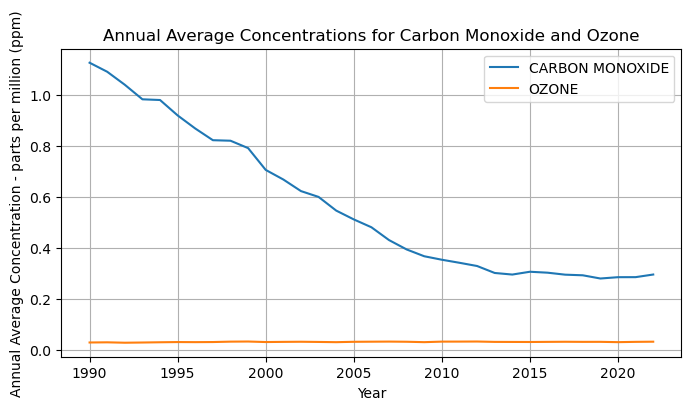

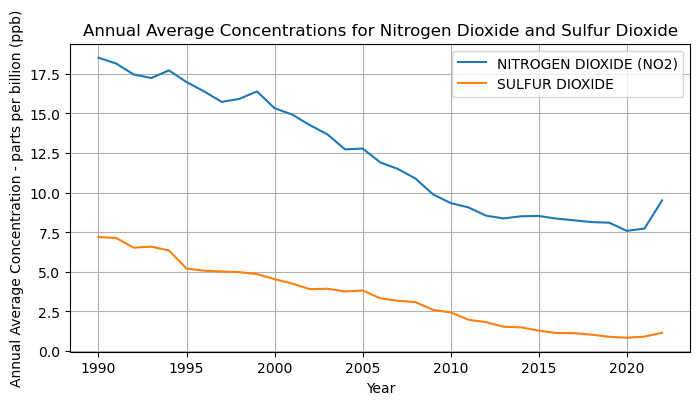

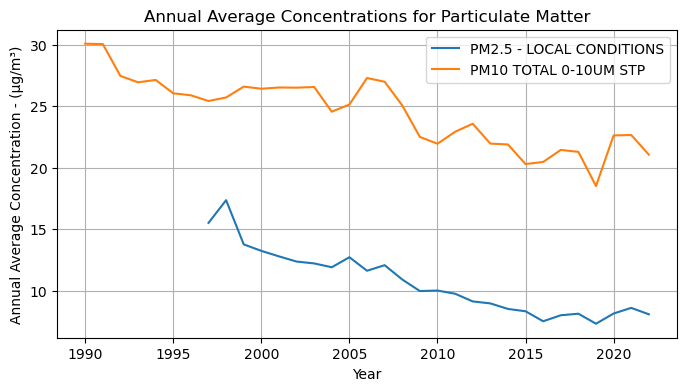

In [49]:
from pyspark.sql.functions import year, avg, col
import matplotlib.pyplot as plt

# Get the distinct parameter names
parameter_names = all_pollutants_merged.select("parameter_name").distinct().collect()
parameter_names = [row.parameter_name for row in parameter_names]

# Calculate annual average for each pollutant
annual_avg_data = {}

for parameter_name in parameter_names:
    annual_avg = all_pollutants_merged \
        .filter(col('parameter_name') == parameter_name) \
        .groupBy(year(col('date_local')).alias('year')) \
        .agg(avg(col('arithmetic_mean')).alias(f'annual_avg_{parameter_name}')) \
        .orderBy('year') \
        .toPandas()
    annual_avg_data[parameter_name] = annual_avg

# Define pollutant groups for each chart
chart1_pollutants = ['Carbon monoxide', 'Ozone']
chart2_pollutants = ['Nitrogen dioxide (NO2)', 'Sulfur dioxide']
chart3_pollutants = ['PM2.5 - Local Conditions', 'PM10 Total 0-10um STP']

# Plot the annual average concentrations for Chart 1 pollutants
plt.figure(figsize=(8, 4))

for parameter_name in chart1_pollutants:
    annual_avg_pd = annual_avg_data[parameter_name]
    plt.plot(annual_avg_pd['year'], annual_avg_pd[f'annual_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Year')
plt.ylabel('Annual Average Concentration - parts per million (ppm)')
plt.title('Annual Average Concentrations for Carbon Monoxide and Ozone')
plt.legend()
plt.grid()
plt.show()

# Plot the annual average concentrations for Chart 2 pollutants
plt.figure(figsize=(8, 4))

for parameter_name in chart2_pollutants:
    annual_avg_pd = annual_avg_data[parameter_name]
    plt.plot(annual_avg_pd['year'], annual_avg_pd[f'annual_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Year')
plt.ylabel('Annual Average Concentration - parts per billion (ppb)')
plt.title('Annual Average Concentrations for Nitrogen Dioxide and Sulfur Dioxide')
plt.legend()
plt.grid()
plt.show()

# Plot the annual average concentrations for Chart 3 pollutants
plt.figure(figsize=(8, 4))

for parameter_name in chart3_pollutants:
    annual_avg_pd = annual_avg_data[parameter_name]
    plt.plot(annual_avg_pd['year'], annual_avg_pd[f'annual_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Year')
plt.ylabel('Annual Average Concentration - (µg/m³)')
plt.title('Annual Average Concentrations for Particulate Matter')
plt.legend()
plt.grid()
plt.show()

### 5.3. State Event Type Count  

The EPA Historical Air Quality data set also includes information on events that are known to impact air quality.  Some examples of exceptional events are wildfire, high wind dust events, prescribed fires，stratospheric ozone intrusion，and volcanic and seismic activities. The table and graph that follow show that California has the highest event count of any state. Drawing on information from the New York Times, we assess the following to be drivers in California's high count of events (Pierre-Louis & Schwartz, 2021).

> 1. __Climate__: California has a Mediterranean climate, which means it has long, dry summers with high temperatures and low humidity. These conditions are ideal for creating dry vegetation that is prone to wildfires. One example is 2020 wildfire where over `9,600` fires burned more than 4 million acres of land. 
> 
> 2. __Geography__: California is located on the Pacific Ring of Fire, which is a region of high volcanic and seismic activity. In 2021, the state experienced a series of small earthquakes in the San Francisco Bay Area, with the largest measuring at a magnitude of `3.8` on the Richter scale.
> 
> 3. __Human Activities__: Many wildfires in California are caused by human activity, such as unattended campfires, discarded cigarettes, and arson. The high population density in some parts of the state can also increase the risk of exceptional events.

It's worth noting that wildfires are a natural part of California's ecosystem, and some degree of wildfire activity is necessary for maintaining healthy ecosystems. However, the frequency and severity of events in recent years has raised concerns about their impact on people and property.


In [50]:
# Find the total counts in each state 
from pyspark.sql.functions import desc, col,count
state_included_event = all_pollutants_merged.select("state_name","event_type","arithmetic_mean")\
                  .where(all_pollutants_merged.event_type == "Included")\
                   .groupBy("state_name").agg(count("state_name").alias("Included Count")
                                             ).orderBy(desc("Included Count"))

state_excluded_event = all_pollutants_merged.select("state_name","event_type","arithmetic_mean")\
                  .where(all_pollutants_merged.event_type == "Excluded")\
                   .groupBy("state_name").agg(count("state_name").alias("Excluded Count")
                                             ).orderBy(desc("Excluded Count"))

event_table = state_included_event.join(state_excluded_event, on = "state_name", how ="left_outer")

count_table = event_table.withColumn('Total Count', col('Included Count') + col('Excluded Count'))
count_table.orderBy(desc('Total Count')).limit(10).toPandas()

,state_name,Included Count,Excluded Count,Total Count
0,California,159118,1659,160777
1,Hawaii,76970,31378,108348
2,Michigan,101416,12,101428
3,Indiana,87961,1,87962
4,Colorado,76566,522,77088
5,North Carolina,65842,16,65858
6,Tennessee,49024,177,49201
7,Texas,48450,211,48661
8,Kentucky,45382,407,45789
9,North Dakota,42685,6,42691


In the table above, `Included` events are those that the EPA was able to measure.  `Excluded` events were those that took place where an air quality measurement was not captured.  `Total Count` is the sum of both types of events.

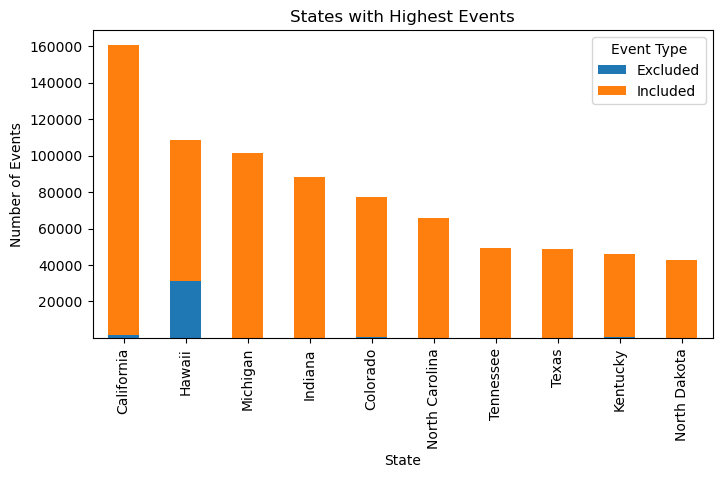

In [15]:
# Bar Plot of Top 10 event count states 
from pyspark.sql.functions import col, count
import pandas as pd
import matplotlib.pyplot as plt

# Replace ‘dataframe’ with the appropriate DataFrame variable containing state and event type info
# Replace ‘state_column’ and ‘event_type_column’ with the appropriate column names for state & event type
# Filter out the rows with ‘None’ as event type
filtered_df = all_pollutants_merged.filter(col('event_type') != 'None')

# Group by state and event type, and count the number of occurrences for each state
state_event_counts = filtered_df.groupBy('state_name', 'event_type') \
     .agg(count('event_type').alias('event_type_count')) \
     .toPandas()

# Calculate the total count for each state
state_total_counts = state_event_counts.groupby('state_name')['event_type_count'].sum().reset_index()

# Get the top 10 states by total count and sort by descending order
top_10_states = state_total_counts.nlargest(10, 'event_type_count').sort_values(by='event_type_count', 
                                                                                ascending=False)
# Filter the state_event_counts DataFrame to include only the top 10 states
state_event_counts_top_10 = state_event_counts[state_event_counts['state_name']
                                               .isin(top_10_states['state_name'])]

# Create a pivot table with the top 10 states
pivot_table = state_event_counts_top_10.pivot_table(index='state_name', columns='event_type', 
                                                    values='event_type_count', fill_value=0)

# Sort the pivot table by the total event type count in descending order
pivot_table['total_event_type_count'] = pivot_table.sum(axis=1)
pivot_table_sorted = pivot_table.sort_values(by='total_event_type_count', 
                                             ascending=False).drop('total_event_type_count', axis=1)

# Create a stacked bar plot of event type count for the top 10 states ordered by total event type count
pivot_table_sorted.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.xlabel('State')
plt.ylabel('Number of Events')
plt.title('States with Highest Events')
plt.legend(title='Event Type')
plt.show()

The above table makes clear that California has the highest number of recorded climate events.  Hawaii has the highest number of `Excluded` events. This may be due in part to the island state's few sites, or perhaps its geographic separation from the contiguous United States.  We will explore events more in the next version of this notebook.

### 5.4. Case Study: Measurements in California

#### 5.4.1. Annual Trends in California

The results show that Carbon Monoxide and Nitrogen Dioxide show a decreasing trend from 1990 - 2020, while Ozone and Sulfur dioxide seems to keep a horizitoal link which means the same level from 1990 - 2020. In contrast, $ PM_{10} $ and $ PM_{2.5} $ exhibit a more fluctuant trend in those years. $ PM_{2.5} $ reaches a peak in the year 1998 and decreased a lot after 1998. The annual trend of six pollutants is affected by many external and internal factors, so we will do deeper analysis in the following sections. 

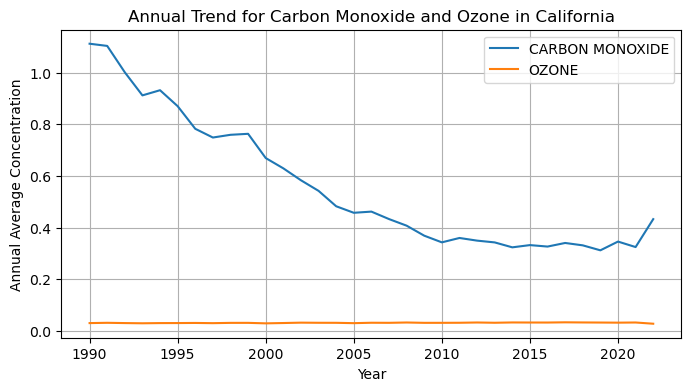

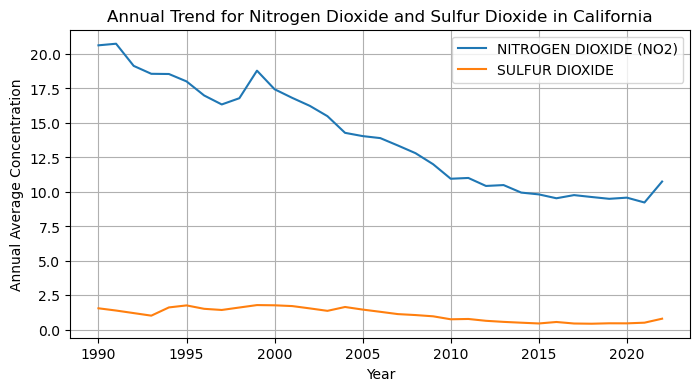

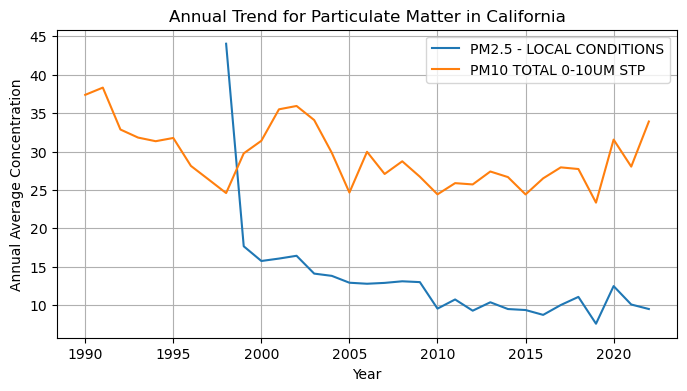

In [4]:
from pyspark.sql.functions import year, avg, col
import matplotlib.pyplot as plt

# Filter the data for California only
cali = all_pollutants_merged.filter(col('state_name') == 'California')

# Get the distinct parameter names
parameter_names = cali.select("parameter_name").distinct().collect()
parameter_names = [row.parameter_name for row in parameter_names]

# Calculate monthly average for each pollutant
yearly_avg_data = {}

for parameter_name in parameter_names:
    yearly_avg = cali \
        .filter(col('parameter_name') == parameter_name) \
        .groupBy(year(col('date_local')).alias('year')) \
        .agg(avg(col('arithmetic_mean')).alias(f'yearly_avg_{parameter_name}')).orderBy('year') \
        .toPandas()
    yearly_avg_data[parameter_name] = yearly_avg
    
# Define pollutant groups for each chart
chart1_pollutants = ['Carbon monoxide', 'Ozone']
chart2_pollutants = ['Nitrogen dioxide (NO2)', 'Sulfur dioxide']
chart3_pollutants = ['PM2.5 - Local Conditions', 'PM10 Total 0-10um STP']

# Plot the monthly average concentrations for CO and O3
plt.figure(figsize=(8, 4))

for parameter_name in chart1_pollutants:
    yearly_avg_pd = yearly_avg_data[parameter_name]
    plt.plot(yearly_avg_pd['year'], yearly_avg_pd[f'yearly_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Year')
plt.ylabel('Annual Average Concentration')
plt.title('Annual Trend for Carbon Monoxide and Ozone in California')
plt.legend()
plt.grid()
plt.show()

# Plot the monthly average concentrations for NO2 and SO2
plt.figure(figsize=(8, 4))

for parameter_name in chart2_pollutants:
    yearly_avg_pd = yearly_avg_data[parameter_name]
    plt.plot(yearly_avg_pd['year'], yearly_avg_pd[f'yearly_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Year')
plt.ylabel('Annual Average Concentration')
plt.title('Annual Trend for Nitrogen Dioxide and Sulfur Dioxide in California')
plt.legend()
plt.grid()
plt.show()

# Plot the monthly average concentrations for PM
plt.figure(figsize=(8, 4))

for parameter_name in chart3_pollutants:
    yearly_avg_pd = yearly_avg_data[parameter_name]
    plt.plot(yearly_avg_pd['year'], yearly_avg_pd[f'yearly_avg_{parameter_name}'], 
             label=parameter_name.upper())
    
plt.xlabel('Year')
plt.ylabel('Annual Average Concentration')
plt.title('Annual Trend for Particulate Matter in California')
plt.legend()
plt.grid()
plt.show()

#### 5.4.2. Seasonality Trends in California

The results show that Carbon Monoxide and Nitrogen Dioxide have lower average concentrations during the spring and summer months (April to August), while Ozone tends to increase during these months. In contrast, Sulfur Dioxide and $ PM_{2.5} $ exhibit higher average concentrations during the winter months (October to December). Notably, there is a clear decrease in average $ PM_{10} $ concentrations from October to December.  This is intuitive, since home heating increases during colder months, and dust storms and construction activity decrease around the same time.

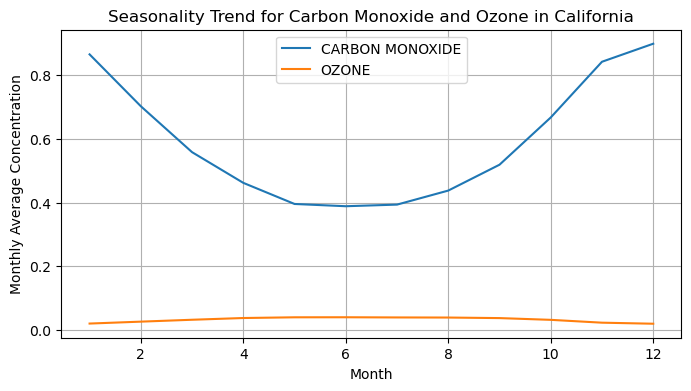

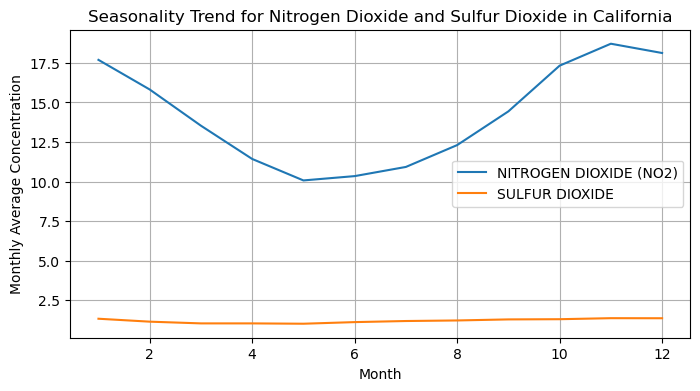

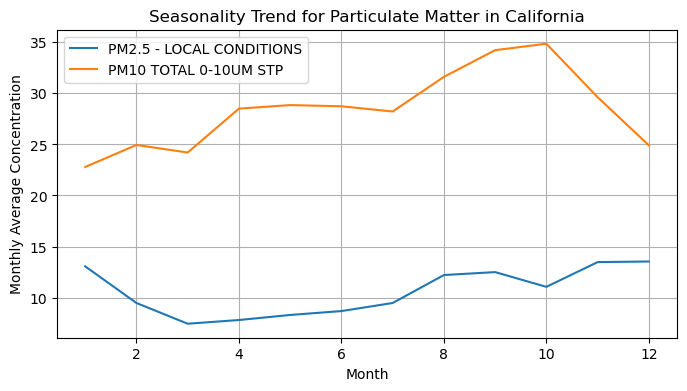

In [21]:
from pyspark.sql.functions import month, avg, col
import matplotlib.pyplot as plt

# Filter the data for California only
cali = all_pollutants_merged.filter(col('state_name') == 'California')

# Get the distinct parameter names
parameter_names = cali.select("parameter_name").distinct().collect()
parameter_names = [row.parameter_name for row in parameter_names]

# Calculate monthly average for each pollutant
monthly_avg_data = {}

for parameter_name in parameter_names:
    monthly_avg = cali \
        .filter(col('parameter_name') == parameter_name) \
        .groupBy(month(col('date_local')).alias('month')) \
        .agg(avg(col('arithmetic_mean')).alias(f'monthly_avg_{parameter_name}')) \
        .orderBy('month') \
        .toPandas()
    monthly_avg_data[parameter_name] = monthly_avg

# Define pollutant groups for each chart
chart1_pollutants = ['Carbon monoxide', 'Ozone']
chart2_pollutants = ['Nitrogen dioxide (NO2)', 'Sulfur dioxide']
chart3_pollutants = ['PM2.5 - Local Conditions', 'PM10 Total 0-10um STP']

# Plot the monthly average concentrations for CO and O3
plt.figure(figsize=(8, 4))

for parameter_name in chart1_pollutants:
    monthly_avg_pd = monthly_avg_data[parameter_name]
    plt.plot(monthly_avg_pd['month'], monthly_avg_pd[f'monthly_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Month')
plt.ylabel('Monthly Average Concentration')
plt.title('Seasonality Trend for Carbon Monoxide and Ozone in California')
plt.legend()
plt.grid()
plt.show()

# Plot the monthly average concentrations for NO2 and SO2
plt.figure(figsize=(8, 4))

for parameter_name in chart2_pollutants:
    monthly_avg_pd = monthly_avg_data[parameter_name]
    plt.plot(monthly_avg_pd['month'], monthly_avg_pd[f'monthly_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Month')
plt.ylabel('Monthly Average Concentration')
plt.title('Seasonality Trend for Nitrogen Dioxide and Sulfur Dioxide in California')
plt.legend()
plt.grid()
plt.show()

# Plot the monthly average concentrations for PM
plt.figure(figsize=(8, 4))

for parameter_name in chart3_pollutants:
    monthly_avg_pd = monthly_avg_data[parameter_name]
    plt.plot(monthly_avg_pd['month'], monthly_avg_pd[f'monthly_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Month')
plt.ylabel('Monthly Average Concentration')
plt.title('Seasonality Trend for Particulate Matter in California')
plt.legend()
plt.grid()
plt.show()

#### 5.4.3. Wind and Temperature in California

##### 5.4.3.1. Wind Trend

The graph indicates that the highest average wind speed in California occurred in 2022, which could be attributed to climate change and environmental factors. Drought can lead to increased wind speeds as dry soil and vegetation increase the amount of dust and fine particles that can be lifted by the wind. Wildfires can also lead to increased wind speeds as heat generated by the fire can create strong updrafts and downdrafts. Sea level rise can impact coastal wind patterns and lead to changes in wind speed and direction as sea breezes and land breezes are affected.

Additionally, there were peaks in average wind speed between 2006 and 2007, and in 2021. It is possible that changes in land use, such as urbanization, could impact wind patterns and contribute to these peaks. Urbanization impact wind patterns as buildings and other structures create obstacles that can change wind speed and direction.

In [11]:
from pyspark.sql.functions import col

# Filter for records where state_name is "California"
california_county_codes_df = all_pollutants_merged.filter(col("state_name") == "California")

# Select distinct values of county_code column
distinct_county_codes = california_county_codes_df.select("county_code").distinct()

# Collect the distinct county codes as a list
county_codes_list = [row.county_code for row in distinct_county_codes.collect()]

# Print the distinct county codes for California
print("Distinct County Codes in California: ", county_codes_list)

Distinct County Codes in California:  ['101', '073', '065', '087', '053', '113', '061', '037', '013', '107', '067', '031', '075', '081', '019', '097', '047', '071', '025', '111', '055', '089', '045', '029', '059', '001', '077', '039', '095', '079', '041', '083', '017', '007', '043', '085', '099', '057', '023', '009', '093', '027', '069', '015', '033', '011', '051', '103', '115', '105', '063', '021', '005', '035', '049', '091', '109']


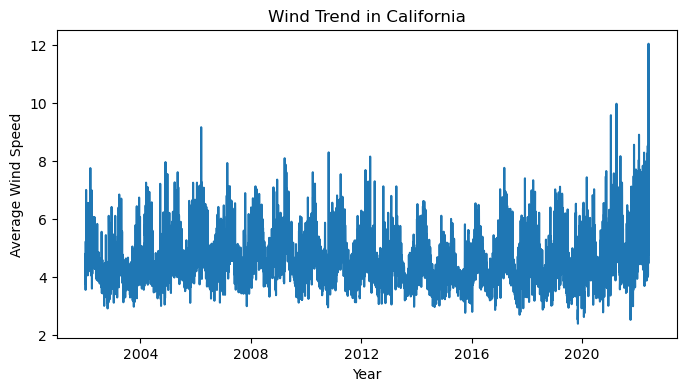

In [16]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import year
from pyspark.sql.types import IntegerType

# Filter the DataFrame for California using county_codes_list
cali_df = twentyYears_df.filter(twentyYears_df["county_code"].isin(county_codes_list))

# Convert date_local column to date type
cali_df = cali_df.withColumn('date_local', cali_df['date_local'].cast('date'))

# Group the data by date_local and calculate the mean of wind_arithmetic_mean
wind_trend = cali_df.groupBy('date_local') \
    .agg({'wind_arithmetic_mean': 'mean'}) \
    .sort('date_local')

# Extract the date_local and wind_arithmetic_mean columns as Pandas DataFrame
wind_trend_pd = wind_trend.select('date_local', 'avg(wind_arithmetic_mean)').toPandas()

# Plot the wind trend
plt.figure(figsize=(8, 4))
plt.plot(wind_trend_pd['date_local'], wind_trend_pd['avg(wind_arithmetic_mean)'])
plt.xlabel('Year')
plt.ylabel('Average Wind Speed')
plt.title('Wind Trend in California')
plt.show()

##### 5.4.3.2. Temperature Trend in Summer

The bar chart of average summer temperatures in California over the past `20` years shows a relatively stable trend. This could be due to a number of factors, including the influence of ocean currents and the Mediterranean climate of California. The California coast is characterized by cool ocean currents that help regulate temperatures and prevent extreme fluctuations. Additionally, California's Mediterranean climate, with its mild, wet winters and warm, dry summers, also helps to moderate temperatures throughout the state.

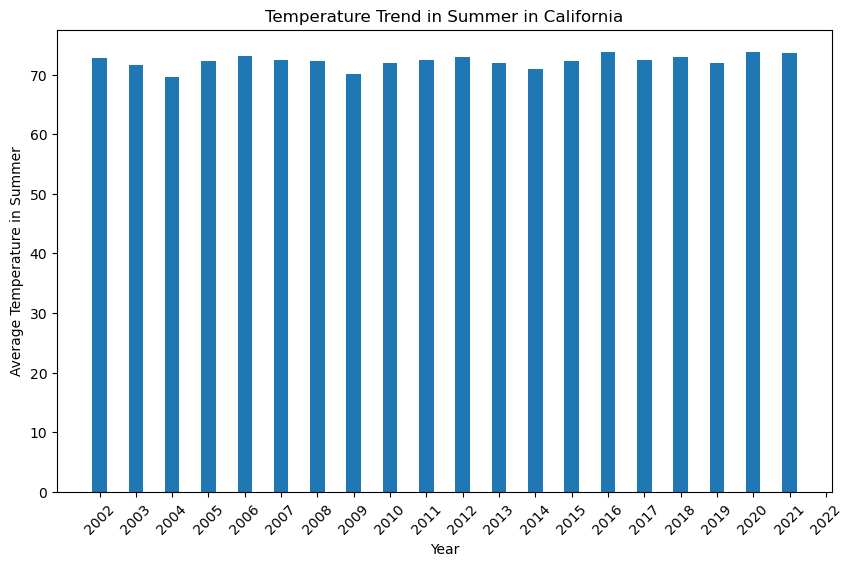

In [15]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import year, month
from pyspark.sql.types import IntegerType

# Filter the DataFrame for California
cali_df = twentyYears_df.filter(twentyYears_df["county_code"].isin(county_codes_list))

# Convert date_local column to date type
cali_df = cali_df.withColumn('date_local', cali_df['date_local'].cast('date'))

# Filter the data for summer months (June, July, August)
cali_df = cali_df.filter((month('date_local').cast(IntegerType()) >= 6) 
                         & (month('date_local').cast(IntegerType()) <= 8))

# Group the data by year and calculate the mean of temperature_arithmetic_mean
temp_trend = cali_df.groupBy(year('date_local').alias('year')) \
    .agg({'temperature_arithmetic_mean': 'mean'}) \
    .sort('year')

# Extract the year and temperature_arithmetic_mean columns as Pandas DataFrame
temp_trend_pd = temp_trend.select('year', 'avg(temperature_arithmetic_mean)').toPandas()

# Plot the temperature trend
plt.figure(figsize=(10, 6))
plt.bar(temp_trend_pd['year'], temp_trend_pd['avg(temperature_arithmetic_mean)'], width=0.4)
plt.xticks(temp_trend_pd['year'])
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('Average Temperature in Summer')
plt.title('Temperature Trend in Summer in California')
plt.show()

##### 5.4.3.3. Temperature Trend in Winter

The bar chart shows that the temperatures before 2012 were generally higher compared to the temperatures after 2012. Starting from 2016 and 2022, there is a noticeable decrease in average winter temperatures. This could be due to various reasons such as increasing levels of air pollution. Air pollution can affect temperature by absorbing or reflecting incoming sunlight. High levels of air pollution can lead to a cooling effect by scattering and reflecting sunlight, but it can also have a warming effect by absorbing and trapping heat. In California, air pollution from wildfires and traffic has been shown to contribute to the change of temperatures, particularly in urban areas.

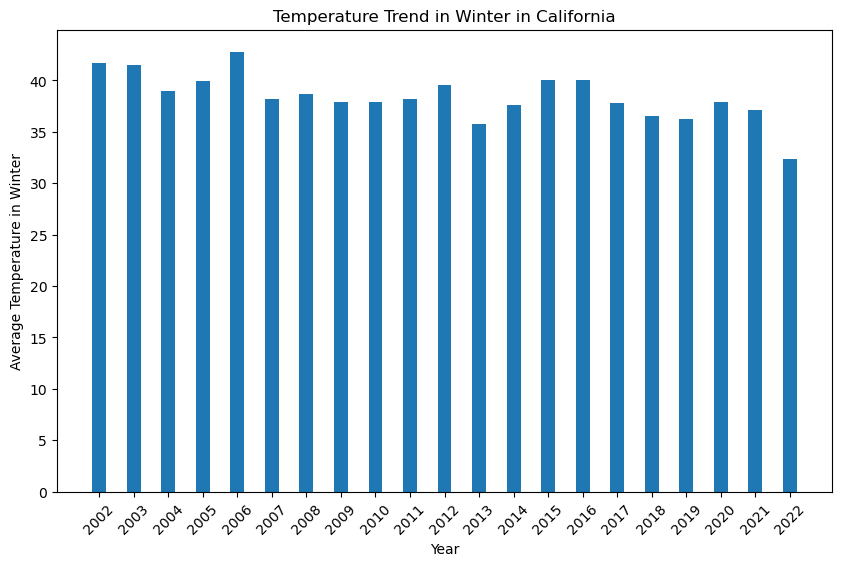

In [16]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import year, month
from pyspark.sql.types import IntegerType

# Filter the DataFrame for California
cali_df = twentyYears_df.filter(twentyYears_df["county_code"].isin(county_codes_list))

# Convert date_local column to date type
cali_df = cali_df.withColumn('date_local', cali_df['date_local'].cast('date'))

# Filter the data for winter months (November, December, January)
cali_df = cali_df.filter((month('date_local').cast(IntegerType()) >= 11) 
                         | (month('date_local').cast(IntegerType()) <= 1))

# Group the data by year and calculate the mean of temperature_arithmetic_mean
temp_trend = cali_df.groupBy(year('date_local').alias('year')) \
    .agg({'temperature_arithmetic_mean': 'mean'}) \
    .sort('year')

# Extract the year and temperature_arithmetic_mean columns as Pandas DataFrame
temp_trend_pd = temp_trend.select('year', 'avg(temperature_arithmetic_mean)').toPandas()

# Plot the temperature trend
plt.figure(figsize=(10, 6))
plt.bar(temp_trend_pd['year'], temp_trend_pd['avg(temperature_arithmetic_mean)'], width=0.4)
plt.xticks(temp_trend_pd['year'])
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('Average Temperature in Winter')
plt.title('Temperature Trend in Winter in California')
plt.show()

#### 5.4.4. AQI in Butte County California

In order to capture a visual representation of AQI, the index driven by each of these six pollutants, we plotted the following AQI lifecycle for Butte County California. While the mean AQI, shown by the bold line, consistently remains in the Good and Moderate zones, individual months were marked by Very Unhealthy AQI.

Since AQI is measured for each pollutant, the graph that follows captures all air quality indices for each of the six pollutants we are tracking. AQI is a `0-500` scale representing the potential health concerns posed by concentrations of airborne pollutants. `0-50` AQI is considered Good, `50-100` is Moderate, `100-150` is Unhealthy for Sensitive Groups--such as those with breathing problems or cardiovascular conditions, `150-200` is Unhealthy, `200-300` is Very Unhealthy, and over `300` is Hazardous.  For certain pollutants, like $ PM_{2.5} $, AQI can exceed `500`, although the EPA does not have a designated category for these extreme indices.

We noticed two peaks in Butte County California. Those two peaks represent the Camp Fire in 2018 and the North Complex Fire in 2020.

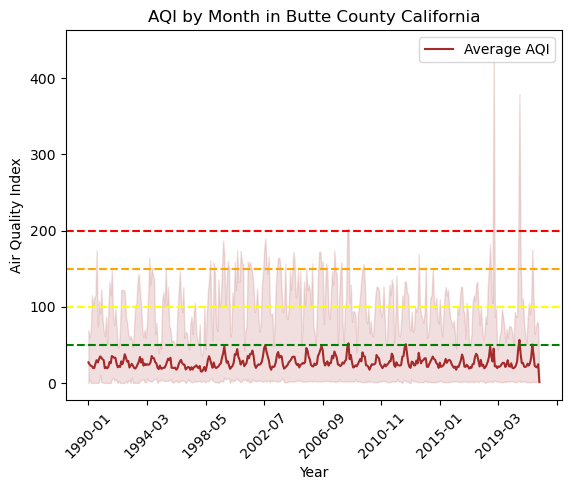

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from pyspark.sql.functions import when, col, min, max, avg
from pyspark.sql.functions import year, month, date_trunc

# Define the conditions for each aqi category
condition1 = (col("aqi") > 0) & (col("aqi") <= 50)
condition2 = (col("aqi") > 50) & (col("aqi") <= 100)
condition3 = (col("aqi") > 100)& (col("aqi") <= 150)
condition4 = (col("aqi") > 150) & (col("aqi") <= 200)
condition5 = (col("aqi") > 200) & (col("aqi") <= 300)
condition6 = (col("aqi") > 300)

# Apply the conditions and set the values for each category
AQILevel = when(condition1, "Good") \
                .when(condition2, "Moderate") \
                .when(condition3, "Unhealthy for Sensitive Groups") \
                .when(condition4, "Unhealthy") \
                .when(condition5,"Very Unhealthy") \
                .when(condition6,"Hazardous") \
                .otherwise("Unknown")

# Add the new column to the DataFrame
all_pollutants_merged = all_pollutants_merged.withColumn("AQI Level", AQILevel)

# Isolate site_num 0010 & state_code 34 = New York
ca_daily = all_pollutants_merged.where((all_pollutants_merged['state_code'] == '06') &
                                      (all_pollutants_merged['county_name'] == 'Butte'))

# Change the date into the first day of month
ca_daily = ca_daily.withColumn("year_month", date_trunc("month", "date_local"))

# Calculate average, min, and max AQI
ca_monthly = ca_daily.groupBy("year_month").agg(min("aqi"), max("aqi"), avg("aqi"))
ca_monthly_pd = ca_monthly.select("year_month","max(aqi)","min(aqi)","avg(aqi)").toPandas()
ca_monthly_pd['year_month'] = ca_monthly_pd['year_month'].dt.strftime('%Y-%m')
ca_monthly_pd = ca_monthly_pd.sort_values('year_month')

# Plot the lines for min, max, and avg
ax = ca_monthly_pd.plot(x='year_month', y='avg(aqi)', color = 'brown')
ax.fill_between(x = 'year_month', y1='min(aqi)', y2='max(aqi)', 
                data=ca_monthly_pd,color=mpl.colors.to_rgba('brown', 0.15))
ax.legend(labels=["Average AQI"], loc='upper right')

# Draw the horizontal lines for AQI level
plt.axhline(y = 50, color='green', linestyle='--')
plt.axhline(y = 100, color='yellow', linestyle='--')
plt.axhline(y = 150, color='orange', linestyle='--')
plt.axhline(y = 200, color='red', linestyle='--')
#plt.axhline(y = 300, color='purple', linestyle='--')

# Set the axis labels and title and plot the graph
plt.xlabel('Year')
plt.ylabel('Air Quality Index')
plt.xticks(rotation = 45)
plt.title('AQI by Month in Butte County California')
plt.show()

#### 5.4.5. Specific Events in California and Their Impact on Pollutants

In this section, we will analyze three famous and specific environmental disasters in California to understand what happened in the air. We will focus on Carbon Monoxide, $ PM_{2.5} $ and $ PM_{10} $ because those three pollutants have more immediate and direct impacts on human health compare with $ SO_2 $, $ NO_2 $, and $ O_3 $ which need longer time to show impact which means it is hard to tell the effect in one event. 

##### 5.4.5.1. Earthquake in San Francisco

There were several small earthquakes in the San Francisco Bay Area in 2021. The largest earthquake of the series, as we mentioned before, measured `3.8` on the Richter scale and occurred on May 23, 2021. We can see from the graph that after May, all three pollutants experienced fluctant trends especially for $ PM_{10} $ which means the air quality is affected a lot and the concentration also increase beause earthquake will cause the dust and dust will affect the $ PM_{10} $ and $ PM_{2.5} $ directly. 

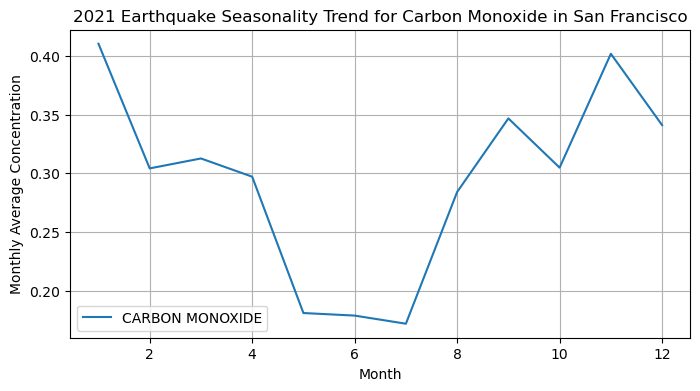

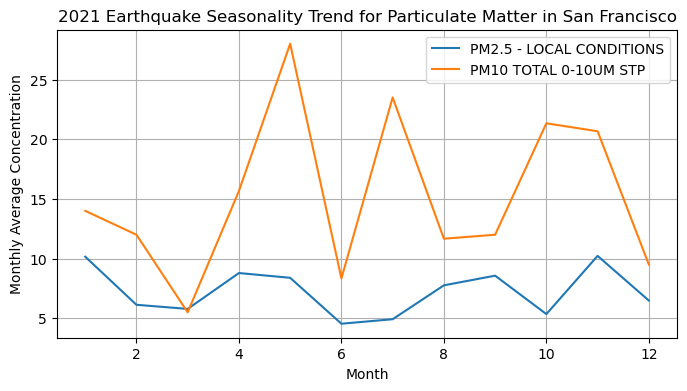

In [3]:
from pyspark.sql.functions import month, avg, col,year
import matplotlib.pyplot as plt

# Filter the data for California only
SF = all_pollutants_merged.filter((col('county_name') == 'San Francisco') & (year(col('date_local')) == 2021))

# Get the distinct parameter names
parameter_names = SF.select("parameter_name").distinct().collect()
parameter_names = [row.parameter_name for row in parameter_names]

# Calculate monthly average for each pollutant
monthly_avg_data = {}

for parameter_name in parameter_names:
    monthly_avg = SF \
        .filter(col('parameter_name') == parameter_name) \
        .groupBy(month(col('date_local')).alias('month')) \
        .agg(avg(col('arithmetic_mean')).alias(f'monthly_avg_{parameter_name}')) \
        .orderBy('month') \
        .toPandas()
    monthly_avg_data[parameter_name] = monthly_avg

# Define pollutant groups for each chart
chart1_pollutants = ['Carbon monoxide']
chart2_pollutants = ['PM2.5 - Local Conditions', 'PM10 Total 0-10um STP']

# Plot the monthly average concentrations for CO 
plt.figure(figsize=(8, 4))

for parameter_name in chart1_pollutants:
    monthly_avg_pd = monthly_avg_data[parameter_name]
    plt.plot(monthly_avg_pd['month'], monthly_avg_pd[f'monthly_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Month')
plt.ylabel('Monthly Average Concentration')
plt.title('2021 Earthquake Seasonality Trend for Carbon Monoxide in San Francisco')
plt.legend()
plt.grid()
plt.show()

# Plot the monthly average concentrations for PM
plt.figure(figsize=(8, 4))

for parameter_name in chart2_pollutants:
    monthly_avg_pd = monthly_avg_data[parameter_name]
    plt.plot(monthly_avg_pd['month'], monthly_avg_pd[f'monthly_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Month')
plt.ylabel('Monthly Average Concentration')
plt.title('2021 Earthquake Seasonality Trend for Particulate Matter in San Francisco')
plt.legend()
plt.grid()
plt.show()

##### 5.4.5.2. Wildfire in Butte

The Dixie Fire, which started on July 13, 2021, in Butte County, has burned over `960,000` acres, making it one of the largest wildfires in California's history (California Department of Forestry and Fire Prevention). The fire destroyed over `1,300` structures and caused several injuries. Wildfire will cause Carbon Monoxide and the graph shows that there is a drastically increase of Carbon Monoxide in July which correspond to the event and $ PM_{2.5} $ and $ PM_{10} $ also increase a lot at the same time. The smoke form the fire increase the concentration of those plloutants on July and the following months.  

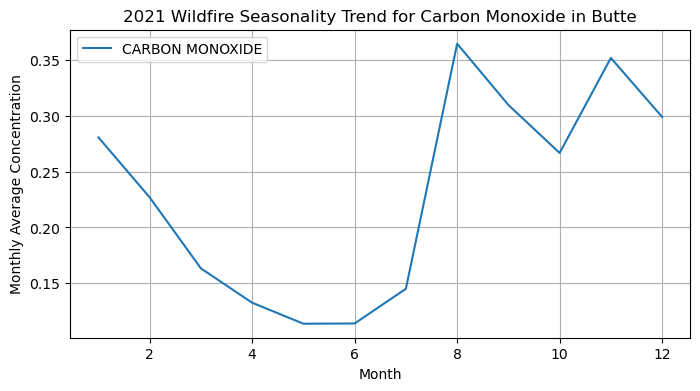

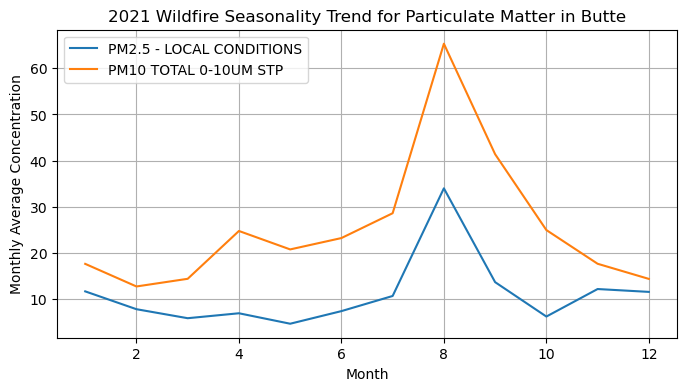

In [6]:
from pyspark.sql.functions import month, avg, col
import matplotlib.pyplot as plt

# Filter the data for California only
Butte = all_pollutants_merged.filter((col('county_name') == 'Butte') & (year(col('date_local')) == 2021))

# Get the distinct parameter names
parameter_names = Butte.select("parameter_name").distinct().collect()
parameter_names = [row.parameter_name for row in parameter_names]

# Calculate monthly average for each pollutant
monthly_avg_data = {}

for parameter_name in parameter_names:
    monthly_avg = Butte \
        .filter(col('parameter_name') == parameter_name) \
        .groupBy(month(col('date_local')).alias('month')) \
        .agg(avg(col('arithmetic_mean')).alias(f'monthly_avg_{parameter_name}')) \
        .orderBy('month') \
        .toPandas()
    monthly_avg_data[parameter_name] = monthly_avg

# Define pollutant groups for each chart
chart1_pollutants = ['Carbon monoxide']
chart2_pollutants = ['PM2.5 - Local Conditions', 'PM10 Total 0-10um STP']

# Plot the monthly average concentrations for CO and O3
plt.figure(figsize=(8, 4))

for parameter_name in chart1_pollutants:
    monthly_avg_pd = monthly_avg_data[parameter_name]
    plt.plot(monthly_avg_pd['month'], monthly_avg_pd[f'monthly_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Month')
plt.ylabel('Monthly Average Concentration')
plt.title('2021 Wildfire Seasonality Trend for Carbon Monoxide in Butte')
plt.legend()
plt.grid()
plt.show()

# Plot the monthly average concentrations for PM
plt.figure(figsize=(8, 4))

for parameter_name in chart2_pollutants:
    monthly_avg_pd = monthly_avg_data[parameter_name]
    plt.plot(monthly_avg_pd['month'], monthly_avg_pd[f'monthly_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Month')
plt.ylabel('Monthly Average Concentration')
plt.title('2021 Wildfire Seasonality Trend for Particulate Matter in Butte')
plt.legend()
plt.grid()
plt.show()

#### 5.4.6. Legislations in 2002, 2004, 2006

California government proposed different legislation in 2002 , 2004 and 2006 to protect the environment (California Air Resources Board). 

- __2002:__ The California Clean Air Act (AB 2042) - This legislation updated the state's clean air standards to reduce emissions of harmful pollutants such as nitrogen oxides and particulate matter.

- __2004:__ The Goods Movement Action Plan (SB 927) - This legislation established a plan to reduce emissions from the transportation of goods through measures such as increased use of cleaner technologies and improved traffic flow.

- __2006:__ The Heavy-Duty Diesel Vehicle Idling Emissions Reduction Act (SB 1207) - This legislation established regulations to limit the amount of time that heavy-duty diesel vehicles can idle, in order to reduce emissions.

From the graph, we can clearly find that all six pollutants show decreasing trend from 2002 to 2008 and the trends mean the success of those legislations and demonstrate California's commitment to improving air quality and reducing emissions of harmful pollutants. 

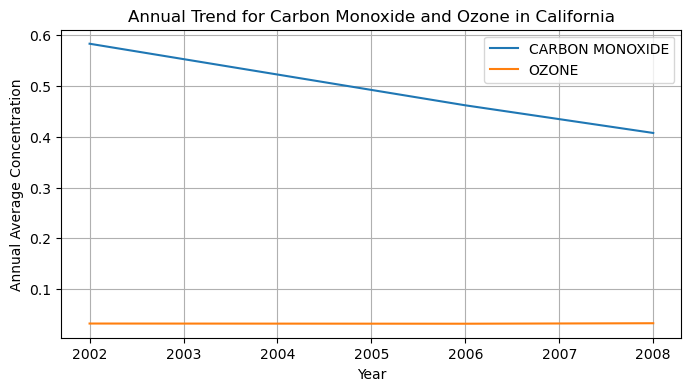

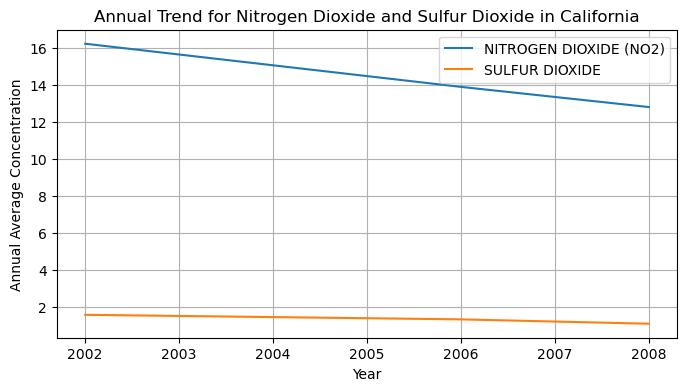

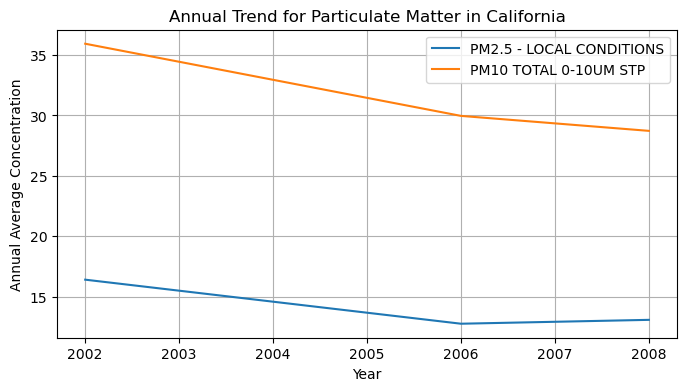

In [6]:
from pyspark.sql.functions import year, avg, col
import matplotlib.pyplot as plt

# Filter the data for California only
cali = all_pollutants_merged.filter(col('state_name') == 'California')

# Get the distinct parameter names
parameter_names = cali.select("parameter_name").distinct().collect()
parameter_names = [row.parameter_name for row in parameter_names]

# Calculate monthly average for each pollutant
yearly_avg_data = {}

for parameter_name in parameter_names:
    yearly_avg = cali \
        .filter(col('parameter_name') == parameter_name) \
        .groupBy(year(col('date_local')).alias('year')) \
        .agg(avg(col('arithmetic_mean')).alias(f'yearly_avg_{parameter_name}')) \
        .filter(col('year').isin([2002, 2006, 2008])).orderBy('year') \
        .toPandas()
    yearly_avg_data[parameter_name] = yearly_avg

# Define pollutant groups for each chart
chart1_pollutants = ['Carbon monoxide', 'Ozone']
chart2_pollutants = ['Nitrogen dioxide (NO2)', 'Sulfur dioxide']
chart3_pollutants = ['PM2.5 - Local Conditions', 'PM10 Total 0-10um STP']

# Plot the monthly average concentrations for CO and O3
plt.figure(figsize=(8, 4))

for parameter_name in chart1_pollutants:
    yearly_avg_pd = yearly_avg_data[parameter_name]
    plt.plot(yearly_avg_pd['year'], yearly_avg_pd[f'yearly_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Year')
plt.ylabel('Annual Average Concentration')
plt.title('Annual Trend for Carbon Monoxide and Ozone in California')
plt.legend()
plt.grid()
plt.show()

# Plot the monthly average concentrations for NO2 and SO2
plt.figure(figsize=(8, 4))

for parameter_name in chart2_pollutants:
    yearly_avg_pd = yearly_avg_data[parameter_name]
    plt.plot(yearly_avg_pd['year'], yearly_avg_pd[f'yearly_avg_{parameter_name}'], 
             label=parameter_name.upper())

plt.xlabel('Year')
plt.ylabel('Annual Average Concentration')
plt.title('Annual Trend for Nitrogen Dioxide and Sulfur Dioxide in California')
plt.legend()
plt.grid()
plt.show()

# Plot the monthly average concentrations for PM
plt.figure(figsize=(8, 4))

for parameter_name in chart3_pollutants:
    yearly_avg_pd = yearly_avg_data[parameter_name]
    plt.plot(yearly_avg_pd['year'], yearly_avg_pd[f'yearly_avg_{parameter_name}'], 
             label=parameter_name.upper())
    
plt.xlabel('Year')
plt.ylabel('Annual Average Concentration')
plt.title('Annual Trend for Particulate Matter in California')
plt.legend()
plt.grid()
plt.show()

#### 5.4.7. Event Count in in California over the Years

While the California government has proposed various legislation and programs to address these environmental challenges, there are still many factors that contribute to their persistence and worsening over time. Nevertheless, it is important to recognize that human activities are a major driver of these environmental events like greenhouse gas emissions from transportation, industry, and agriculture, as well as other forms of pollution and land use practices because of the development of contries. Furthermore, human activities also contains burning of fossil fuels, deforestation, and other land use changes that contribute to the release of greenhouse gases into the atmosphere which will cause more frequent and severe heatwaves, droughts, and wildfires. Continued efforts to reduce emissions, protect natural habitats, and improve environmental quality will be necessary to address these challenges.

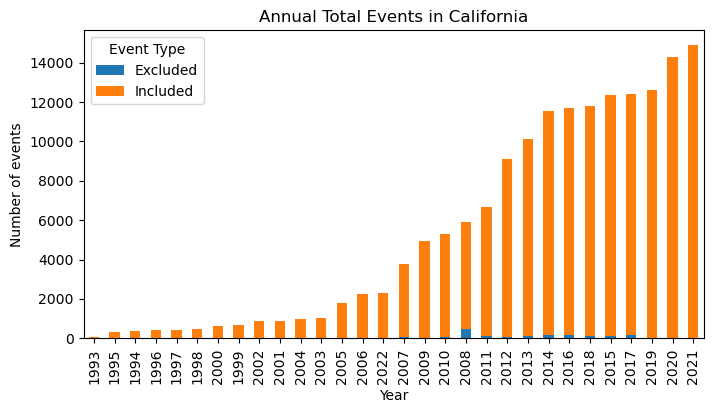

In [7]:
from pyspark.sql.functions import col, count
import pandas as pd
import matplotlib.pyplot as plt

# Replace ‘dataframe’ with the appropriate DataFrame variable containing state and event type info
# Replace ‘state_column’ and ‘event_type_column’ with the appropriate column names for state & event type
# Filter out the rows with ‘None’ as event type
filtered_df = all_pollutants_merged.filter(col('event_type') != 'None')\
                                   .filter(col('state_name') == 'California')

# Group by state and event type, and count the number of occurrences for each state
cali_event_counts = filtered_df.groupBy(year(col('date_local')).alias('Year'), 'event_type') \
     .agg(count('event_type').alias('event_type_count')) \
     .toPandas()
                                                                                
# Create a pivot table with the top 10 states
pivot_table = cali_event_counts.pivot_table(index='Year', columns='event_type', 
                                                    values='event_type_count', fill_value=0)

# Sort the pivot table by the total event type count in descending order
pivot_table['total_cali_event_type_count'] = pivot_table.sum(axis=1)
pivot_table_sorted = pivot_table.sort_values(by='total_cali_event_type_count', 
                                             ascending=True).drop('total_cali_event_type_count', axis=1)

# Create a stacked bar plot of event type count for the top 10 states ordered by total event type count
pivot_table_sorted.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.xlabel('Year')
plt.ylabel('Number of events')
plt.title('Annual Total Events in California')
plt.legend(title='Event Type')
plt.show()

The above graph makes clear that even while pollution concentrations decline in California, climate-impacting events are increasing.  This may be due in part to increased record keeping, or it could be an indicator of 

<a id="part6"></a>
## Part 6: Machine Learning Application


### 6.1. Prediction Task

The United States Environmental Protection Agency publishes a daily index on the health impact of air pollution called the Air Quality Index (AQI).  Each pollutant measured by the EPA has its own AQI, and the highest AQI value for any pollutant in a particular area is the published AQI for that day.  The AQI for each pollutant is calculated using the following formula:

$$I_P = {I_{Hi} - I_{Lo} \over BP_{Hi} - BP_{Lo}} (C_P - BP_{Lo}) + I_{Lo} $$

Where:

> $ I_P $ = the index for pollutant $ P $
> 
> $ C_P $ = the truncated concentration of pollutant $ P $
> 
> $ BP_{Hi} $ = the concentration breakpoint that is greater than or equal to $ C_P $
> 
> $ BP_{Lo} $ = the concentration breakpoint that is less than or equal to $ C_P $
> 
> $ I_{Hi} $ = the AQI value corresponding to $ BP_{Hi} $
> 
> $ I_{Lo} $ = the AQI value corresponding to $ BP_{Lo} $


Since AQI is based on the concentration of pollutants, we wondered if it could be estimated without the need for a Concentration Breakpoint table.  We therefore trained a series of machine learning models to do just that-- using measurements of not only key pollutants, but also wind and temperature, to predict overall AQI.

### 6.2. Data Cleaning for ML

#### 6.2.1. Creating DataFrame for Regression

We first needed to extract the overall AQI, which we call `agg_aqi` from each measurement in our data set.  In order to do that, we wrote a function called `get_highest_aqi_value()`, which returns the highest AQI value for a given date, county code, and site number.  We then run this function on the last 20 years of our data to create a new DataFrame called `agg_aqi_df`.

In [18]:
def get_highest_aqi_value(df: DataFrame):
    
    # Filter the DataFrame to remove any null values in date_local, county_code, and site_num columns
    filtered_df = df.filter(col("date_local").isNotNull() &
                            col("county_code").isNotNull() &
                            col("site_num").isNotNull())

    # Group by date_local, county_code, and site_num, and find the max AQI value from columns ending in "_aqi"
    aqi_cols = [col_name for col_name in filtered_df.columns if col_name.endswith("_aqi")]
    max_aqi_df = filtered_df.groupBy("date_local", "county_code", "site_num")\
    .agg(*[max(col_name).alias(col_name) for col_name in aqi_cols],
         first("temperature_arithmetic_mean").alias("temp"), 
         first("wind_arithmetic_mean").alias("wind"))

    # Impute null AQI values to 0
    max_aqi_df = max_aqi_df.fillna(0)
    
    # Find the max value across all AQI columns using a for loop
    max_aqi = col(aqi_cols[0])
    for col_name in aqi_cols[1:]:
        max_aqi = (when(col(col_name) > max_aqi, col(col_name))
                   .otherwise(max_aqi)) 

    # Add a new column "agg_aqi" with the max value, drop other columns ending in "_aqi"
    df_with_agg_aqi = max_aqi_df.withColumn("agg_aqi", max_aqi).drop(*aqi_cols)

    return df_with_agg_aqi

In [19]:
agg_aqi_df = get_highest_aqi_value(twentyYears_df)

We then join `agg_aqi_df` back into its original DataFrame to capture the measurements other than AQI, and we drop the columns created by `get_highest_aqi_value()`.

In [20]:
mldf = twentyYears_df.join(agg_aqi_df, on=['date_local', 'county_code', 'site_num'], how='left')
    
# Drop unused wind & temp columns, and any duplicate records
cols_to_drop = ["temp", "wind"]
mldf = mldf.drop(*cols_to_drop)
mldf = mldf.dropDuplicates()

# Clear cache and cache mldf
all_pollutants_merged.unpersist()
allyears_df.unpersist()
mldf.rdd.getNumPartitions()
mldf.cache()

DataFrame[date_local: date, county_code: string, site_num: string, co_arithmetic_mean: double, co_aqi: bigint, no2_arithmetic_mean: double, no2_aqi: bigint, o3_arithmetic_mean: double, o3_aqi: bigint, pm10_arithmetic_mean: double, pm10_aqi: bigint, pm25_arithmetic_mean: double, pm25_aqi: bigint, so2_arithmetic_mean: double, so2_aqi: bigint, wind_arithmetic_mean: double, temperature_arithmetic_mean: double, agg_aqi: bigint]

To maximize the data used by our regression within each feature, we then filter our DataFrame to contain only those dates and sites which have measurement for each pollutant, wind, and temperature.  This leaves us with just under 3 million measurements.

In [ ]:
from pyspark.sql.types import DoubleType

# Create DF with only records containing all measurements
dense = mldf.where(col('co_arithmetic_mean').isNotNull() &
           col('no2_arithmetic_mean').isNotNull() &
           col('o3_arithmetic_mean').isNotNull() &
           col('so2_arithmetic_mean').isNotNull() &
           col('pm25_arithmetic_mean').isNotNull() &
           col('wind_arithmetic_mean').isNotNull() &
           col('temperature_arithmetic_mean').isNotNull() &
           col('pm10_arithmetic_mean').isNotNull()).dropDuplicates()

# Cast "agg_aqi" to double
dense = dense.withColumn("agg_aqi", dense["agg_aqi"].cast(DoubleType()))

# Count records, show head
print(dense.count())
dense.limit(10).toPandas()

2914286


,date_local,county_code,site_num,co_arithmetic_mean,co_aqi,no2_arithmetic_mean,no2_aqi,o3_arithmetic_mean,o3_aqi,pm10_arithmetic_mean,pm10_aqi,pm25_arithmetic_mean,pm25_aqi,so2_arithmetic_mean,so2_aqi,wind_arithmetic_mean,temperature_arithmetic_mean,agg_aqi
0,2002-06-13,065,8001,0.670833,9,20.913043,28,0.047471,119,58.0,52,26.3,81,0.000000,0,3.362500,70.666667,119.0
1,2002-06-14,031,0002,0.691667,11,36.608696,50,0.037353,38,45.0,42,14.6,56,5.739130,44,2.412500,69.916667,56.0
2,2002-06-25,067,0006,0.312500,5,13.130435,19,0.066000,185,23.0,21,8.0,33,1.086957,4,2.404348,77.260870,185.0
3,2002-06-25,067,0006,0.312500,5,13.130435,19,0.066000,185,21.0,19,8.0,33,1.086957,4,2.404348,77.260870,185.0
4,2002-06-25,067,0006,0.312500,5,13.130435,19,0.066000,185,26.0,24,8.0,33,1.086957,4,2.404348,77.260870,185.0
5,2002-07-09,141,0037,0.204167,3,14.250000,28,0.052176,93,33.0,31,17.7,63,0.375000,3,5.925000,83.083333,93.0
6,2002-07-25,029,0014,0.000000,0,16.782609,35,0.055471,159,51.0,47,15.8,59,10.500000,37,3.583333,84.125000,159.0
7,2002-07-25,029,0014,0.000000,0,16.782609,35,0.055471,159,51.0,47,16.0,59,10.500000,37,3.583333,84.125000,159.0
8,2002-07-25,029,0014,0.000000,0,16.782609,35,0.055471,159,52.0,48,15.8,59,10.500000,37,3.583333,84.125000,159.0
9,2002-07-25,029,0014,0.000000,0,16.782609,35,0.055471,159,52.0,48,16.0,59,10.500000,37,3.583333,84.125000,159.0


Next, we drop any columns that will not be used to predict AQI, and we store this as `reg_df`.

In [ ]:
cols_to_drop = ['date_local', 'county_code', 'site_num', 'co_aqi', 'no2_aqi',
                'o3_aqi', 'pm10_aqi', 'pm25_aqi', 'so2_aqi']

# Drop unused columns
reg_df = dense.drop(*cols_to_drop)

#### 6.2.2. Controlling for Skewness, Outliers

Since we begin with a linear regression model to predict overall AQI, we want to ensure our data resembles a normal distribution.  We start by taking a look at our label (Y), `agg_aqi`, as well as the features (X) for wind and temperature.

In [ ]:
reg_df.describe(['agg_aqi']).show()

In [45]:
reg_df.describe(['temperature_arithmetic_mean']).show()

+-------+---------------------------+
|summary|temperature_arithmetic_mean|
+-------+---------------------------+
|  count|                    2914286|
|   mean|         57.058250914375805|
| stddev|          20.06956291420116|
|    min|                 -38.916667|
|    max|                      109.0|
+-------+---------------------------+



In [46]:
reg_df.describe(['wind_arithmetic_mean']).show()

+-------+--------------------+
|summary|wind_arithmetic_mean|
+-------+--------------------+
|  count|             2914286|
|   mean|  4.3282902797642455|
| stddev|  3.2814937624812694|
|    min|                 0.0|
|    max|          346.559091|
+-------+--------------------+



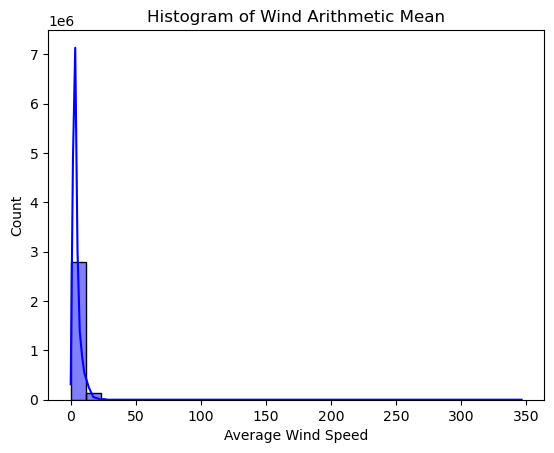

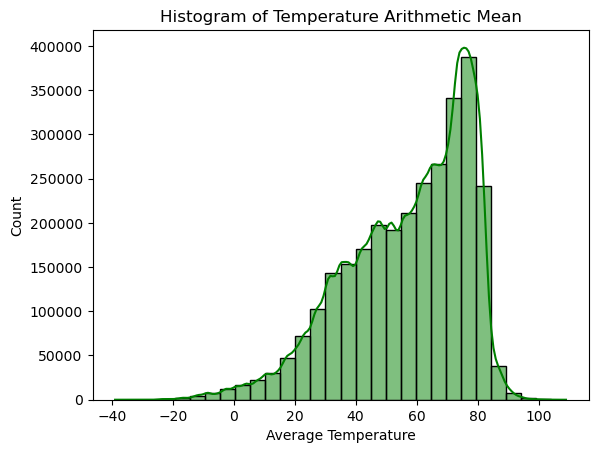

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert reg_df to Pandas for use with Seaborn
reg_df_pd = reg_df.select("wind_arithmetic_mean", "temperature_arithmetic_mean").toPandas()

# Histogram of wind_arithmetic_mean
sns.histplot(data=reg_df_pd, x="wind_arithmetic_mean", kde=True, color='blue', bins=30)
plt.title('Histogram of Wind Arithmetic Mean')
plt.xlabel('Average Wind Speed')
plt.show()

# Histogram of temperature_arithmetic_mean
sns.histplot(data=reg_df_pd, x="temperature_arithmetic_mean", kde=True, color='green', bins=30)
plt.title('Histogram of Temperature Arithmetic Mean')
plt.xlabel('Average Temperature')
plt.show()

Due to the strong right skewness of `wind_arithmetic_mean`, we log transform this variable to make it more balanced.

In [25]:
from pyspark.sql.functions import log

# Take log of wind_arithmetic_mean +1 to avoid log(0)
reg_df_log = reg_df.withColumn("wind_arithmetic_mean_log", log(col("wind_arithmetic_mean") + 1))
reg_df_log = reg_df_log.drop("wind_arithmetic_mean")

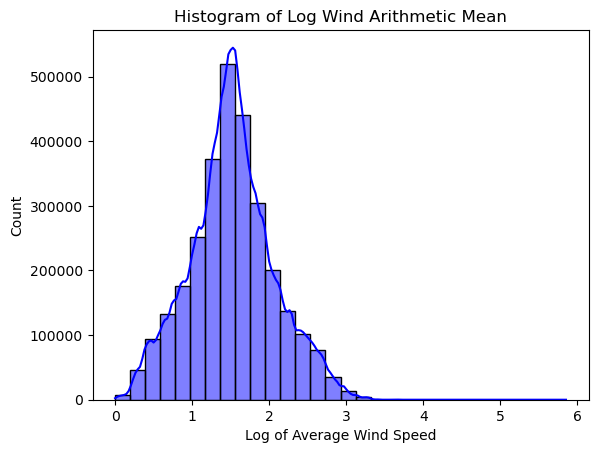

In [27]:
# Updated histogram of wind_arithmetic_mean
sns.histplot(data=reg_df_log.toPandas(), x="wind_arithmetic_mean_log", kde=True, color='blue', bins=30)
plt.title('Histogram of Log Wind Arithmetic Mean')
plt.xlabel('Log of Average Wind Speed')
plt.show()

Finally, we identify and remove outliers by finding those values higher than 1.5 times each feature's interquartile range.

In [28]:
from pyspark.sql.functions import col, expr

def get_outlier_bounds(df, column):
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

wind_lower_bound, wind_upper_bound = get_outlier_bounds(reg_df_log, "wind_arithmetic_mean_log")
temp_lower_bound, temp_upper_bound = get_outlier_bounds(reg_df_log, "temperature_arithmetic_mean")

outliers = reg_df_log.filter(
    (col("wind_arithmetic_mean_log") < wind_lower_bound) | (col("wind_arithmetic_mean_log") > wind_upper_bound) |
    (col("temperature_arithmetic_mean") < temp_lower_bound) | (col("temperature_arithmetic_mean")\
                                                               > temp_upper_bound)
)

outliers.count()

65093

In [29]:
# Remove outliers
clean_df = reg_df_log.filter(
    (col("wind_arithmetic_mean_log") >= wind_lower_bound) & (col("wind_arithmetic_mean_log")\
                                                             <= wind_upper_bound) &
    (col("temperature_arithmetic_mean") >= temp_lower_bound) & (col("temperature_arithmetic_mean")\
                                                                <= temp_upper_bound)
)

clean_df.cache()

DataFrame[co_arithmetic_mean: double, no2_arithmetic_mean: double, o3_arithmetic_mean: double, pm10_arithmetic_mean: double, pm25_arithmetic_mean: double, so2_arithmetic_mean: double, temperature_arithmetic_mean: double, agg_aqi: double, wind_arithmetic_mean_log: double]

### 6.3. Linear Regression

We begin with a simple linear regression to assess the feasibility of our task, although we suspect the relationship between our features and label to be nonlinear.  We will measure the performance of the linear regression with root mean squared error, which has the same units as `agg_aqi`. $ R^2 $ is a measure of fit from 0 to 1 representing how closely a predictive model fits the training data.

In [30]:
from pyspark.ml.feature import RFormula
from pyspark.ml import Pipeline

In [31]:
supervised = RFormula(formula="agg_aqi ~ .")

fittedRF = supervised.fit(clean_df)

preparedDF = fittedRF.transform(clean_df)

train, test = preparedDF.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Instantiate Linear Regression
lr = LinearRegression(labelCol="label",featuresCol="features")
lrModel = lr.fit(train)

# Predictions on test set
predictions = lrModel.transform(test)

# RMSE
rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")

# R-squared (coefficient of determination)
r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2")

# Calculate RMSE
rmse = rmse_evaluator.evaluate(predictions)

# Calculate R-squared
r2 = r2_evaluator.evaluate(predictions)

In [35]:
# Print the results
print("RMSE: ", rmse)
print("R-squared: ", r2)

RMSE:  16.96059501188669
R-squared:  0.3907515816673097


The results show that a linear regression does not adequately fit our data; however our predictions are only approximately `17` AQI points imprecise on average.

### 6.4. Random Forest Regressor

Next, we use a Random Forest model with `maxDepth` set to `10` to see if this more complex model can better predict aggregate AQI given our features.  Random Forest methods compile an ensemble of decision trees and return their aggregate prediction.  In this case, our `RandomForestRegressor()` will predict the aggregate AQI stored in `agg_aqi`.  We will measure its performance as we did above, however each metric will represent the average prediction of the individual trees in the ensemble.

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# Instantiate RFRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="label", maxDepth=10)
rfModel = rf.fit(train)

In [36]:
# Predictions on test set
predictions = rfModel.transform(test)

# RMSE
rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")

# R-squared (coefficient of determination)
r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2")

# Calculate RMSE
rmse = rmse_evaluator.evaluate(predictions)

# Calculate R-squared
r2 = r2_evaluator.evaluate(predictions)

# Print the results
print("RMSE: ", rmse)
print("R-squared: ", r2)

RMSE:  15.350788961041452
R-squared:  0.5009160030874222


This approach gets us roughly 2 points closer on average to an accurate AQI prediction as measured by RMSE. The higher $ R^2 $ indicates that the more complex `RandomForestRegressor()` is better able to fit our dataset.

### 6.5. Gradient-Boosted Tree Regressor

Finally, we turn to Gradient-Boosted Tree Regressor to assess its predictions of AQI.  Gradient boosting is a technique of ensembles of decision trees that seeks to optimize weak learners, or under performing trees.  For this reason, we expect to see a slightly better RMSE score and a better fit than the Random Forest method.

In [ ]:
from pyspark.ml.regression import GBTRegressor

# Instantiate GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxDepth=10)
gbtModel = gbt.fit(train)

In [37]:
# Predictions on test set
predictions = gbtModel.transform(test)

# Calculate RMSE
rmse = rmse_evaluator.evaluate(predictions)

# Calculate R-squared
r2 = r2_evaluator.evaluate(predictions)

# Print the results
print("RMSE: ", rmse)
print("R-squared: ", r2)

RMSE:  13.607196566992934
R-squared:  0.6078524019075007


This model gets us our closest estimate of AQI in terms of RMSE.  Next, we place the model into a Spark Pipeline to test various hyperparameters' impact on model performance. Hyperparameter tuning is a late phase of machine learning used to maximize performance in models by testing different options for regularization, loss, iterations of training, and many other model features. Since we use grid search to tune our hyperparameters, we must remain cognizant that the pipeline will create all combinations of values in the parameter grid.  The following grid search evaluates `4` total models.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train, test = clean_df.randomSplit([0.8, 0.2], seed=42)

# Define pipeline stages
rForm = RFormula(formula="agg_aqi ~ .")
gbt = GBTRegressor()

# Instantiate pipeline
stages = [rForm, gbt]  
pipeline = Pipeline(stages=stages)

# Parameter grid
params = ParamGridBuilder()\
.addGrid(gbt.maxDepth, [5, 10])\
.addGrid(gbt.stepSize, [0.01, 0.1])\
.build()

# Setting the evaluator as AUC
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")

# Cross-validator
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=params,
                    evaluator=evaluator,
                    numFolds=4, 
                    seed=42)

# Fit the estimator
cvFitted = cv.fit(train) 

# Print the score for each configuration
print("RMSE of each configuration: ", cvFitted.avgMetrics)

# Best model
bestModel = cvFitted.bestModel

In [26]:
# Optimal value of maxDepth
bestDepth = bestModel.stages[1].getMaxDepth()
print("Best maxDepth: ", bestDepth)

# Optimal value of Learning Rate
bestLR = bestModel.stages[1].getStepSize()
print("Best Learning Rate: ", bestLR)

Best maxDepth:  10
Best Learning Rate:  0.1


This small grid search confirms our `GBTRegressor()` model uses the best parameters of those included in the parameter grid.  Our best statistical learning model fits the data with an $ R^2 $ of `0.6078` and an RMSE of `13.6071`.  An RMSE of roughly `13` means that, on average, the predictions made by the model are off by approximately `13` units from the true AQI. Since our AQI values range from `0-500`, a `13` unit difference means that our predictions are off by `2.6`% of the total range.

----

<a id="part7"></a>
## Part 7: Conclusions

Since the inception of the Clean Air Act of 1990, air quality has drastically improved in aggregate across the United States. This is indicated by steep declines in daily measurements of Carbon Monoxide ($ CO $), Sulfur Dioxide ($ SO_2 $), Nitrogen Dioxide ($ NO_2 $), and Particulate Matter 2.5 ($ PM_{2.5} $) and 10 ($ PM_{10} $), although Atmospheric Ozone ($ O_3 $) has remained fairly constant in recent history. It is worth noting that the standard deviation for $ NO_2 $, $ SO_2 $, and $ PM_{2.5} $ and $ PM_{10} $ were much higher in comparision with $ CO $ and $ O_3 $. 

We know, however that the Clean Air Act of 1990 is not the only legislation enacted in the U.S. to restrict pollutants. California's legislature voted to approve new Ambient Air Quality Standards in 2002, 2006, and 2008, a period after which significant air quality improvements can be observed across the state (California Air Resources Board). However, our early exploratory data analysis revealed that California leads all other U.S. States in climate events that may impact air quality. These events include a mix of natural and human-driven environmental hazards like wildfires, earthquakes, volcanic activity, and airborne by-products of manufacturing.

Further, we demonstrated the seasonality of most pollutants, which may be an indicator that temperature and wind also influence airborne concentrations of pollution with changing seasons. To this end, we formulated three machine learning models which predicted Air Quality Index given pollutant concentration, wind, and temperature data, each with varying degrees of success.

We offer the following recommendations about how people can improve air quality in their daily lives. First, increasing the use of renewable energy sources such as solar, wind, and geothermal to reduce greenhouse gas emissions. Second, improving building energy efficiency standards and promoting the use of energy-efficient appliances, lighting, and heating and cooling systems. Third, increasing funding for research and development of new technologies that reduce emissions and improve air quality, such as carbon capture and storage, and hydrogen fuel cells.  Lastly, we urge all people to limit activities which may cause unnecessary combustion of harmful materials or vital natural ecosystems.

----


<a id="part8"></a>
## Part 8: References

> 1. AirNow (2023). Air Quality Index - A Guide to Air Quality and Your Health. _AirNow_. https://www.airnow.gov/aqi/aqi-basics/
> 2. California Air Resources Board (2023). California Ambient Air Quality Standards. _State of California_. https://ww2.arb.ca.gov/resources/california-ambient-air-quality-standards#:~:text=In%201959%20California%20enacted%20legislation,more%20stringent%20than%20national%20standards
> 3. California Department of Forestry and Fire Prevention (2023). Dixie Fire. _State of California_. https://www.fire.ca.gov/incidents/2021/7/13/dixie-fire/
> 4. OpenAI (2023). Chat with GPT-3.5. _OpenAI_. https://chat.openai.com/chat.
> 5. Pierre-Louis, K., Schwartz, J. (2021, July 16). Why Does California Have So Many Wildfires? _The New York Times_. https://www.nytimes.com/article/why-does-california-have-wildfires.html
> 6. Story, R. (2013). Python Visualization: Folium 0.14.0 Quickstart. _Folium_. https://python-visualization.github.io/folium/quickstart.html#Getting-Started
> 7. United States Environmental Protection Agency (2022). Historical Air Quality by the EPA. _Google Cloud_. https://console.cloud.google.com/marketplace/product/epa/historical-air-quality
> 8. United States Environmental Protection Agency (2018). Technical Assistance Document for the Reporting of Daily Air Quality – the Air Quality Index (AQI). _AirNow_. https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf
> 9. United States Environmental Protection Agency (2015). File Formats. _AQS Data Mart_. https://aqs.epa.gov/aqsweb/airdata/FileFormats.html


----


<a id="part9"></a>

## Part 9: Appendix

### Appendix A: Map of EPA Air Pollutant Measurement Sites

<a href="https://ibb.co/MgvT6jX"><img src="https://i.ibb.co/p17Dysm/Screenshot-2023-04-04-143748.png" alt="Screenshot-2023-04-04-143748" border="0" /></a>

----
